In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob, pickle
from tqdm import tqdm
from helper_functions import *
from skimage.feature import hog
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier


/home/ucalegon/pythoconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### PARAMETERS ###
processed_images = False

In [3]:
def load_images_labels(processed_images = False):
    if not processed_images: 
        with open('clf_images/all_vehicles.pickle', 'rb') as f:
            all_vehicles = pickle.load(f)
        f.close()
    else:
        with open('clf_images/all_vehicles_processed.pickle', 'rb') as f:
            all_vehicles = pickle.load(f)
        f.close()

    with open('clf_images/all_vehicles_labels.pickle', 'rb') as f:
        all_vehicles_labels = pickle.load(f)
    f.close()
    
    return all_vehicles, all_vehicles_labels

In [4]:
# Feature gen step - same for both training & prediction

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=12, pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in tqdm(imgs):
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) 

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins) #, bins_range=hist_range
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features
    

In [5]:
def dump_clf(clf, clf_name):
    '''
    Pickle classifier using clf_name
    '''
    if '.pickle' in clf_name:
        pass
    else:
        clf_name += '.pickle'
    with open(clf_name, 'wb') as f:
        pickle.dump(clf, f)
    f.close()
    
    print('Classifier dumped to clfs/{}'.format(clf_name))
    
    return

def load_clf(clf_name):
    with open(clf_name, 'rb') as f:
        clf = pickle.load(f)
    f.close()
    
    return clf
    

In [6]:
def train_clf(features, labels):
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf = XGBClassifier()
    
    clf.fit(X_train_scaled, y_train)
    
    y_test_hat = clf.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_test_hat)
    f1 = f1_score(y_test, y_test_hat)
    clf_report = classification_report(y_test, y_test_hat)
    
    print('Accuracy = {}'.format(accuracy))
    print('f1 Score = {}'.format(f1))
    print('\n')
    print(clf_report)
    
    return clf
    

In [7]:
def train_clf_pipeline():
    images, labels = load_images_labels(processed_images = processed_images)
    
    features = extract_features(images)
    
    with open('features.pickle', 'wb') as f:
        pickle.dump(features, f)
    f.close()
    
    clf = train_clf(features, labels)
    clf_name = 'xgb_{0}'.format(time.strftime('%m-%d-%H-%M'))+'.pickle'
    dump_clf(clf, clf_name)

In [8]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, window_dict, x_overlap=0.75):
    window_list = []
    for y_end in window_dict.keys():
        for win_h in window_dict[y_end]:
            y_start = min(y_end-win_h, img.shape[0])
            x_start = 0
            x_end = min(x_start+win_h, img.shape[1])
            while x_end < img.shape[1]:
                window = ((x_start, y_start), (x_end, y_end))
                window_list.append(window)
                x_start += int(win_h*(1-x_overlap))
                x_end = min(x_start+win_h, img.shape[1])
            x_start = img.shape[1] - win_h
            x_end = img.shape[1]
            window = ((x_start, y_start), (x_end, y_end))
            window_list.append(window)
            
    # Return the list of windows
    return window_list



In [9]:
image = mpimg.imread('test_images/detection_testing/frame_5.png')

window_dict = {
                424: [24],
                448: [24, 32],
                472: [24, 32, 48],
                488: [48, 64, 72],
                504: [72, 96],
                520: [72, 96, 128],
                536: [72, 96, 128],
                552: [96, 128],
                576: [128, 160],
                600: [128, 160, 192],
                624: [160, 192, 216],
                648: [160, 192, 216],
                660: [192, 216]
                }

windows = slide_window(image, window_dict, x_overlap=0.66)
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    


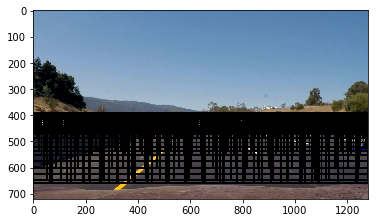

In [10]:
plt.imshow(window_img)

In [11]:
def detect_cars(img, windows, clf):
    window_hats = []
    for window in windows:
        window_hat = []
        sub_img = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        sub_img = resize(sub_img, (64, 64, 3))
        features = extract_features([sub_img])
        print(len(features[0]))
        assert(len(features[0]) == 10224)
        if clf.predict(features) == 1:
            window_hat.append(window)
        window_hats.append(window_hat)
            
    return window_hats
        

In [12]:
clf_name = 'xgb_06-18-05-47.pickle'
clf = load_clf(clf_name)

In [14]:
window_hat = detect_cars(image, windows, clf)

window_hat_img = draw_boxes(image, window_hat)

plt.imshow(window_hat)

/home/ucalegon/pythoconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  0%|          | 0/1 [00:00<?, ?it/s]/home/ucalegon/pythoconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████| 1/1 [00:00<00:00, 46.35it/s]
/home/ucalegon/pythoconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  0%|          | 0/1 [00:00<?, ?it/s]/home/ucalegon/pythoconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`

10224
10224


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999', 'f10000', 'f10001', 'f10002', 'f10003', 'f10004', 'f10005', 'f10006', 'f10007', 'f10008', 'f10009', 'f10010', 'f10011', 'f10012', 'f10013', 'f10014', 'f10015', 'f10016', 'f10017', 'f10018', 'f10019', 'f10020', 'f10021', 'f10022', 'f10023', 'f10024', 'f10025', 'f10026', 'f10027', 'f10028', 'f10029', 'f10030', 'f10031', 'f10032', 'f10033', 'f10034', 'f10035', 'f10036', 'f10037', 'f10038', 'f10039', 'f10040', 'f10041', 'f10042', 'f10043', 'f10044', 'f10045', 'f10046', 'f10047', 'f10048', 'f10049', 'f10050', 'f10051', 'f10052', 'f10053', 'f10054', 'f10055', 'f10056', 'f10057', 'f10058', 'f10059', 'f10060', 'f10061', 'f10062', 'f10063', 'f10064', 'f10065', 'f10066', 'f10067', 'f10068', 'f10069', 'f10070', 'f10071', 'f10072', 'f10073', 'f10074', 'f10075', 'f10076', 'f10077', 'f10078', 'f10079', 'f10080', 'f10081', 'f10082', 'f10083', 'f10084', 'f10085', 'f10086', 'f10087', 'f10088', 'f10089', 'f10090', 'f10091', 'f10092', 'f10093', 'f10094', 'f10095', 'f10096', 'f10097', 'f10098', 'f10099', 'f10100', 'f10101', 'f10102', 'f10103', 'f10104', 'f10105', 'f10106', 'f10107', 'f10108', 'f10109', 'f10110', 'f10111', 'f10112', 'f10113', 'f10114', 'f10115', 'f10116', 'f10117', 'f10118', 'f10119', 'f10120', 'f10121', 'f10122', 'f10123', 'f10124', 'f10125', 'f10126', 'f10127', 'f10128', 'f10129', 'f10130', 'f10131', 'f10132', 'f10133', 'f10134', 'f10135', 'f10136', 'f10137', 'f10138', 'f10139', 'f10140', 'f10141', 'f10142', 'f10143', 'f10144', 'f10145', 'f10146', 'f10147', 'f10148', 'f10149', 'f10150', 'f10151', 'f10152', 'f10153', 'f10154', 'f10155', 'f10156', 'f10157', 'f10158', 'f10159', 'f10160', 'f10161', 'f10162', 'f10163', 'f10164', 'f10165', 'f10166', 'f10167', 'f10168', 'f10169', 'f10170', 'f10171', 'f10172', 'f10173', 'f10174', 'f10175', 'f10176', 'f10177', 'f10178', 'f10179', 'f10180', 'f10181', 'f10182', 'f10183', 'f10184', 'f10185', 'f10186', 'f10187', 'f10188', 'f10189', 'f10190', 'f10191', 'f10192', 'f10193', 'f10194', 'f10195', 'f10196', 'f10197', 'f10198', 'f10199', 'f10200', 'f10201', 'f10202', 'f10203', 'f10204', 'f10205', 'f10206', 'f10207', 'f10208', 'f10209', 'f10210', 'f10211', 'f10212', 'f10213', 'f10214', 'f10215', 'f10216', 'f10217', 'f10218', 'f10219', 'f10220', 'f10221', 'f10222', 'f10223'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861', 'f862', 'f863', 'f864', 'f865', 'f866', 'f867', 'f868', 'f869', 'f870', 'f871', 'f872', 'f873', 'f874', 'f875', 'f876', 'f877', 'f878', 'f879', 'f880', 'f881', 'f882', 'f883', 'f884', 'f885', 'f886', 'f887', 'f888', 'f889', 'f890', 'f891', 'f892', 'f893', 'f894', 'f895', 'f896', 'f897', 'f898', 'f899', 'f900', 'f901', 'f902', 'f903', 'f904', 'f905', 'f906', 'f907', 'f908', 'f909', 'f910', 'f911', 'f912', 'f913', 'f914', 'f915', 'f916', 'f917', 'f918', 'f919', 'f920', 'f921', 'f922', 'f923', 'f924', 'f925', 'f926', 'f927', 'f928', 'f929', 'f930', 'f931', 'f932', 'f933', 'f934', 'f935', 'f936', 'f937', 'f938', 'f939', 'f940', 'f941', 'f942', 'f943', 'f944', 'f945', 'f946', 'f947', 'f948', 'f949', 'f950', 'f951', 'f952', 'f953', 'f954', 'f955', 'f956', 'f957', 'f958', 'f959', 'f960', 'f961', 'f962', 'f963', 'f964', 'f965', 'f966', 'f967', 'f968', 'f969', 'f970', 'f971', 'f972', 'f973', 'f974', 'f975', 'f976', 'f977', 'f978', 'f979', 'f980', 'f981', 'f982', 'f983', 'f984', 'f985', 'f986', 'f987', 'f988', 'f989', 'f990', 'f991', 'f992', 'f993', 'f994', 'f995', 'f996', 'f997', 'f998', 'f999', 'f1000', 'f1001', 'f1002', 'f1003', 'f1004', 'f1005', 'f1006', 'f1007', 'f1008', 'f1009', 'f1010', 'f1011', 'f1012', 'f1013', 'f1014', 'f1015', 'f1016', 'f1017', 'f1018', 'f1019', 'f1020', 'f1021', 'f1022', 'f1023', 'f1024', 'f1025', 'f1026', 'f1027', 'f1028', 'f1029', 'f1030', 'f1031', 'f1032', 'f1033', 'f1034', 'f1035', 'f1036', 'f1037', 'f1038', 'f1039', 'f1040', 'f1041', 'f1042', 'f1043', 'f1044', 'f1045', 'f1046', 'f1047', 'f1048', 'f1049', 'f1050', 'f1051', 'f1052', 'f1053', 'f1054', 'f1055', 'f1056', 'f1057', 'f1058', 'f1059', 'f1060', 'f1061', 'f1062', 'f1063', 'f1064', 'f1065', 'f1066', 'f1067', 'f1068', 'f1069', 'f1070', 'f1071', 'f1072', 'f1073', 'f1074', 'f1075', 'f1076', 'f1077', 'f1078', 'f1079', 'f1080', 'f1081', 'f1082', 'f1083', 'f1084', 'f1085', 'f1086', 'f1087', 'f1088', 'f1089', 'f1090', 'f1091', 'f1092', 'f1093', 'f1094', 'f1095', 'f1096', 'f1097', 'f1098', 'f1099', 'f1100', 'f1101', 'f1102', 'f1103', 'f1104', 'f1105', 'f1106', 'f1107', 'f1108', 'f1109', 'f1110', 'f1111', 'f1112', 'f1113', 'f1114', 'f1115', 'f1116', 'f1117', 'f1118', 'f1119', 'f1120', 'f1121', 'f1122', 'f1123', 'f1124', 'f1125', 'f1126', 'f1127', 'f1128', 'f1129', 'f1130', 'f1131', 'f1132', 'f1133', 'f1134', 'f1135', 'f1136', 'f1137', 'f1138', 'f1139', 'f1140', 'f1141', 'f1142', 'f1143', 'f1144', 'f1145', 'f1146', 'f1147', 'f1148', 'f1149', 'f1150', 'f1151', 'f1152', 'f1153', 'f1154', 'f1155', 'f1156', 'f1157', 'f1158', 'f1159', 'f1160', 'f1161', 'f1162', 'f1163', 'f1164', 'f1165', 'f1166', 'f1167', 'f1168', 'f1169', 'f1170', 'f1171', 'f1172', 'f1173', 'f1174', 'f1175', 'f1176', 'f1177', 'f1178', 'f1179', 'f1180', 'f1181', 'f1182', 'f1183', 'f1184', 'f1185', 'f1186', 'f1187', 'f1188', 'f1189', 'f1190', 'f1191', 'f1192', 'f1193', 'f1194', 'f1195', 'f1196', 'f1197', 'f1198', 'f1199', 'f1200', 'f1201', 'f1202', 'f1203', 'f1204', 'f1205', 'f1206', 'f1207', 'f1208', 'f1209', 'f1210', 'f1211', 'f1212', 'f1213', 'f1214', 'f1215', 'f1216', 'f1217', 'f1218', 'f1219', 'f1220', 'f1221', 'f1222', 'f1223', 'f1224', 'f1225', 'f1226', 'f1227', 'f1228', 'f1229', 'f1230', 'f1231', 'f1232', 'f1233', 'f1234', 'f1235', 'f1236', 'f1237', 'f1238', 'f1239', 'f1240', 'f1241', 'f1242', 'f1243', 'f1244', 'f1245', 'f1246', 'f1247', 'f1248', 'f1249', 'f1250', 'f1251', 'f1252', 'f1253', 'f1254', 'f1255', 'f1256', 'f1257', 'f1258', 'f1259', 'f1260', 'f1261', 'f1262', 'f1263', 'f1264', 'f1265', 'f1266', 'f1267', 'f1268', 'f1269', 'f1270', 'f1271', 'f1272', 'f1273', 'f1274', 'f1275', 'f1276', 'f1277', 'f1278', 'f1279', 'f1280', 'f1281', 'f1282', 'f1283', 'f1284', 'f1285', 'f1286', 'f1287', 'f1288', 'f1289', 'f1290', 'f1291', 'f1292', 'f1293', 'f1294', 'f1295', 'f1296', 'f1297', 'f1298', 'f1299', 'f1300', 'f1301', 'f1302', 'f1303', 'f1304', 'f1305', 'f1306', 'f1307', 'f1308', 'f1309', 'f1310', 'f1311', 'f1312', 'f1313', 'f1314', 'f1315', 'f1316', 'f1317', 'f1318', 'f1319', 'f1320', 'f1321', 'f1322', 'f1323', 'f1324', 'f1325', 'f1326', 'f1327', 'f1328', 'f1329', 'f1330', 'f1331', 'f1332', 'f1333', 'f1334', 'f1335', 'f1336', 'f1337', 'f1338', 'f1339', 'f1340', 'f1341', 'f1342', 'f1343', 'f1344', 'f1345', 'f1346', 'f1347', 'f1348', 'f1349', 'f1350', 'f1351', 'f1352', 'f1353', 'f1354', 'f1355', 'f1356', 'f1357', 'f1358', 'f1359', 'f1360', 'f1361', 'f1362', 'f1363', 'f1364', 'f1365', 'f1366', 'f1367', 'f1368', 'f1369', 'f1370', 'f1371', 'f1372', 'f1373', 'f1374', 'f1375', 'f1376', 'f1377', 'f1378', 'f1379', 'f1380', 'f1381', 'f1382', 'f1383', 'f1384', 'f1385', 'f1386', 'f1387', 'f1388', 'f1389', 'f1390', 'f1391', 'f1392', 'f1393', 'f1394', 'f1395', 'f1396', 'f1397', 'f1398', 'f1399', 'f1400', 'f1401', 'f1402', 'f1403', 'f1404', 'f1405', 'f1406', 'f1407', 'f1408', 'f1409', 'f1410', 'f1411', 'f1412', 'f1413', 'f1414', 'f1415', 'f1416', 'f1417', 'f1418', 'f1419', 'f1420', 'f1421', 'f1422', 'f1423', 'f1424', 'f1425', 'f1426', 'f1427', 'f1428', 'f1429', 'f1430', 'f1431', 'f1432', 'f1433', 'f1434', 'f1435', 'f1436', 'f1437', 'f1438', 'f1439', 'f1440', 'f1441', 'f1442', 'f1443', 'f1444', 'f1445', 'f1446', 'f1447', 'f1448', 'f1449', 'f1450', 'f1451', 'f1452', 'f1453', 'f1454', 'f1455', 'f1456', 'f1457', 'f1458', 'f1459', 'f1460', 'f1461', 'f1462', 'f1463', 'f1464', 'f1465', 'f1466', 'f1467', 'f1468', 'f1469', 'f1470', 'f1471', 'f1472', 'f1473', 'f1474', 'f1475', 'f1476', 'f1477', 'f1478', 'f1479', 'f1480', 'f1481', 'f1482', 'f1483', 'f1484', 'f1485', 'f1486', 'f1487', 'f1488', 'f1489', 'f1490', 'f1491', 'f1492', 'f1493', 'f1494', 'f1495', 'f1496', 'f1497', 'f1498', 'f1499', 'f1500', 'f1501', 'f1502', 'f1503', 'f1504', 'f1505', 'f1506', 'f1507', 'f1508', 'f1509', 'f1510', 'f1511', 'f1512', 'f1513', 'f1514', 'f1515', 'f1516', 'f1517', 'f1518', 'f1519', 'f1520', 'f1521', 'f1522', 'f1523', 'f1524', 'f1525', 'f1526', 'f1527', 'f1528', 'f1529', 'f1530', 'f1531', 'f1532', 'f1533', 'f1534', 'f1535', 'f1536', 'f1537', 'f1538', 'f1539', 'f1540', 'f1541', 'f1542', 'f1543', 'f1544', 'f1545', 'f1546', 'f1547', 'f1548', 'f1549', 'f1550', 'f1551', 'f1552', 'f1553', 'f1554', 'f1555', 'f1556', 'f1557', 'f1558', 'f1559', 'f1560', 'f1561', 'f1562', 'f1563', 'f1564', 'f1565', 'f1566', 'f1567', 'f1568', 'f1569', 'f1570', 'f1571', 'f1572', 'f1573', 'f1574', 'f1575', 'f1576', 'f1577', 'f1578', 'f1579', 'f1580', 'f1581', 'f1582', 'f1583', 'f1584', 'f1585', 'f1586', 'f1587', 'f1588', 'f1589', 'f1590', 'f1591', 'f1592', 'f1593', 'f1594', 'f1595', 'f1596', 'f1597', 'f1598', 'f1599', 'f1600', 'f1601', 'f1602', 'f1603', 'f1604', 'f1605', 'f1606', 'f1607', 'f1608', 'f1609', 'f1610', 'f1611', 'f1612', 'f1613', 'f1614', 'f1615', 'f1616', 'f1617', 'f1618', 'f1619', 'f1620', 'f1621', 'f1622', 'f1623', 'f1624', 'f1625', 'f1626', 'f1627', 'f1628', 'f1629', 'f1630', 'f1631', 'f1632', 'f1633', 'f1634', 'f1635', 'f1636', 'f1637', 'f1638', 'f1639', 'f1640', 'f1641', 'f1642', 'f1643', 'f1644', 'f1645', 'f1646', 'f1647', 'f1648', 'f1649', 'f1650', 'f1651', 'f1652', 'f1653', 'f1654', 'f1655', 'f1656', 'f1657', 'f1658', 'f1659', 'f1660', 'f1661', 'f1662', 'f1663', 'f1664', 'f1665', 'f1666', 'f1667', 'f1668', 'f1669', 'f1670', 'f1671', 'f1672', 'f1673', 'f1674', 'f1675', 'f1676', 'f1677', 'f1678', 'f1679', 'f1680', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686', 'f1687', 'f1688', 'f1689', 'f1690', 'f1691', 'f1692', 'f1693', 'f1694', 'f1695', 'f1696', 'f1697', 'f1698', 'f1699', 'f1700', 'f1701', 'f1702', 'f1703', 'f1704', 'f1705', 'f1706', 'f1707', 'f1708', 'f1709', 'f1710', 'f1711', 'f1712', 'f1713', 'f1714', 'f1715', 'f1716', 'f1717', 'f1718', 'f1719', 'f1720', 'f1721', 'f1722', 'f1723', 'f1724', 'f1725', 'f1726', 'f1727', 'f1728', 'f1729', 'f1730', 'f1731', 'f1732', 'f1733', 'f1734', 'f1735', 'f1736', 'f1737', 'f1738', 'f1739', 'f1740', 'f1741', 'f1742', 'f1743', 'f1744', 'f1745', 'f1746', 'f1747', 'f1748', 'f1749', 'f1750', 'f1751', 'f1752', 'f1753', 'f1754', 'f1755', 'f1756', 'f1757', 'f1758', 'f1759', 'f1760', 'f1761', 'f1762', 'f1763', 'f1764', 'f1765', 'f1766', 'f1767', 'f1768', 'f1769', 'f1770', 'f1771', 'f1772', 'f1773', 'f1774', 'f1775', 'f1776', 'f1777', 'f1778', 'f1779', 'f1780', 'f1781', 'f1782', 'f1783', 'f1784', 'f1785', 'f1786', 'f1787', 'f1788', 'f1789', 'f1790', 'f1791', 'f1792', 'f1793', 'f1794', 'f1795', 'f1796', 'f1797', 'f1798', 'f1799', 'f1800', 'f1801', 'f1802', 'f1803', 'f1804', 'f1805', 'f1806', 'f1807', 'f1808', 'f1809', 'f1810', 'f1811', 'f1812', 'f1813', 'f1814', 'f1815', 'f1816', 'f1817', 'f1818', 'f1819', 'f1820', 'f1821', 'f1822', 'f1823', 'f1824', 'f1825', 'f1826', 'f1827', 'f1828', 'f1829', 'f1830', 'f1831', 'f1832', 'f1833', 'f1834', 'f1835', 'f1836', 'f1837', 'f1838', 'f1839', 'f1840', 'f1841', 'f1842', 'f1843', 'f1844', 'f1845', 'f1846', 'f1847', 'f1848', 'f1849', 'f1850', 'f1851', 'f1852', 'f1853', 'f1854', 'f1855', 'f1856', 'f1857', 'f1858', 'f1859', 'f1860', 'f1861', 'f1862', 'f1863', 'f1864', 'f1865', 'f1866', 'f1867', 'f1868', 'f1869', 'f1870', 'f1871', 'f1872', 'f1873', 'f1874', 'f1875', 'f1876', 'f1877', 'f1878', 'f1879', 'f1880', 'f1881', 'f1882', 'f1883', 'f1884', 'f1885', 'f1886', 'f1887', 'f1888', 'f1889', 'f1890', 'f1891', 'f1892', 'f1893', 'f1894', 'f1895', 'f1896', 'f1897', 'f1898', 'f1899', 'f1900', 'f1901', 'f1902', 'f1903', 'f1904', 'f1905', 'f1906', 'f1907', 'f1908', 'f1909', 'f1910', 'f1911', 'f1912', 'f1913', 'f1914', 'f1915', 'f1916', 'f1917', 'f1918', 'f1919', 'f1920', 'f1921', 'f1922', 'f1923', 'f1924', 'f1925', 'f1926', 'f1927', 'f1928', 'f1929', 'f1930', 'f1931', 'f1932', 'f1933', 'f1934', 'f1935', 'f1936', 'f1937', 'f1938', 'f1939', 'f1940', 'f1941', 'f1942', 'f1943', 'f1944', 'f1945', 'f1946', 'f1947', 'f1948', 'f1949', 'f1950', 'f1951', 'f1952', 'f1953', 'f1954', 'f1955', 'f1956', 'f1957', 'f1958', 'f1959', 'f1960', 'f1961', 'f1962', 'f1963', 'f1964', 'f1965', 'f1966', 'f1967', 'f1968', 'f1969', 'f1970', 'f1971', 'f1972', 'f1973', 'f1974', 'f1975', 'f1976', 'f1977', 'f1978', 'f1979', 'f1980', 'f1981', 'f1982', 'f1983', 'f1984', 'f1985', 'f1986', 'f1987', 'f1988', 'f1989', 'f1990', 'f1991', 'f1992', 'f1993', 'f1994', 'f1995', 'f1996', 'f1997', 'f1998', 'f1999', 'f2000', 'f2001', 'f2002', 'f2003', 'f2004', 'f2005', 'f2006', 'f2007', 'f2008', 'f2009', 'f2010', 'f2011', 'f2012', 'f2013', 'f2014', 'f2015', 'f2016', 'f2017', 'f2018', 'f2019', 'f2020', 'f2021', 'f2022', 'f2023', 'f2024', 'f2025', 'f2026', 'f2027', 'f2028', 'f2029', 'f2030', 'f2031', 'f2032', 'f2033', 'f2034', 'f2035', 'f2036', 'f2037', 'f2038', 'f2039', 'f2040', 'f2041', 'f2042', 'f2043', 'f2044', 'f2045', 'f2046', 'f2047', 'f2048', 'f2049', 'f2050', 'f2051', 'f2052', 'f2053', 'f2054', 'f2055', 'f2056', 'f2057', 'f2058', 'f2059', 'f2060', 'f2061', 'f2062', 'f2063', 'f2064', 'f2065', 'f2066', 'f2067', 'f2068', 'f2069', 'f2070', 'f2071', 'f2072', 'f2073', 'f2074', 'f2075', 'f2076', 'f2077', 'f2078', 'f2079', 'f2080', 'f2081', 'f2082', 'f2083', 'f2084', 'f2085', 'f2086', 'f2087', 'f2088', 'f2089', 'f2090', 'f2091', 'f2092', 'f2093', 'f2094', 'f2095', 'f2096', 'f2097', 'f2098', 'f2099', 'f2100', 'f2101', 'f2102', 'f2103', 'f2104', 'f2105', 'f2106', 'f2107', 'f2108', 'f2109', 'f2110', 'f2111', 'f2112', 'f2113', 'f2114', 'f2115', 'f2116', 'f2117', 'f2118', 'f2119', 'f2120', 'f2121', 'f2122', 'f2123', 'f2124', 'f2125', 'f2126', 'f2127', 'f2128', 'f2129', 'f2130', 'f2131', 'f2132', 'f2133', 'f2134', 'f2135', 'f2136', 'f2137', 'f2138', 'f2139', 'f2140', 'f2141', 'f2142', 'f2143', 'f2144', 'f2145', 'f2146', 'f2147', 'f2148', 'f2149', 'f2150', 'f2151', 'f2152', 'f2153', 'f2154', 'f2155', 'f2156', 'f2157', 'f2158', 'f2159', 'f2160', 'f2161', 'f2162', 'f2163', 'f2164', 'f2165', 'f2166', 'f2167', 'f2168', 'f2169', 'f2170', 'f2171', 'f2172', 'f2173', 'f2174', 'f2175', 'f2176', 'f2177', 'f2178', 'f2179', 'f2180', 'f2181', 'f2182', 'f2183', 'f2184', 'f2185', 'f2186', 'f2187', 'f2188', 'f2189', 'f2190', 'f2191', 'f2192', 'f2193', 'f2194', 'f2195', 'f2196', 'f2197', 'f2198', 'f2199', 'f2200', 'f2201', 'f2202', 'f2203', 'f2204', 'f2205', 'f2206', 'f2207', 'f2208', 'f2209', 'f2210', 'f2211', 'f2212', 'f2213', 'f2214', 'f2215', 'f2216', 'f2217', 'f2218', 'f2219', 'f2220', 'f2221', 'f2222', 'f2223', 'f2224', 'f2225', 'f2226', 'f2227', 'f2228', 'f2229', 'f2230', 'f2231', 'f2232', 'f2233', 'f2234', 'f2235', 'f2236', 'f2237', 'f2238', 'f2239', 'f2240', 'f2241', 'f2242', 'f2243', 'f2244', 'f2245', 'f2246', 'f2247', 'f2248', 'f2249', 'f2250', 'f2251', 'f2252', 'f2253', 'f2254', 'f2255', 'f2256', 'f2257', 'f2258', 'f2259', 'f2260', 'f2261', 'f2262', 'f2263', 'f2264', 'f2265', 'f2266', 'f2267', 'f2268', 'f2269', 'f2270', 'f2271', 'f2272', 'f2273', 'f2274', 'f2275', 'f2276', 'f2277', 'f2278', 'f2279', 'f2280', 'f2281', 'f2282', 'f2283', 'f2284', 'f2285', 'f2286', 'f2287', 'f2288', 'f2289', 'f2290', 'f2291', 'f2292', 'f2293', 'f2294', 'f2295', 'f2296', 'f2297', 'f2298', 'f2299', 'f2300', 'f2301', 'f2302', 'f2303', 'f2304', 'f2305', 'f2306', 'f2307', 'f2308', 'f2309', 'f2310', 'f2311', 'f2312', 'f2313', 'f2314', 'f2315', 'f2316', 'f2317', 'f2318', 'f2319', 'f2320', 'f2321', 'f2322', 'f2323', 'f2324', 'f2325', 'f2326', 'f2327', 'f2328', 'f2329', 'f2330', 'f2331', 'f2332', 'f2333', 'f2334', 'f2335', 'f2336', 'f2337', 'f2338', 'f2339', 'f2340', 'f2341', 'f2342', 'f2343', 'f2344', 'f2345', 'f2346', 'f2347', 'f2348', 'f2349', 'f2350', 'f2351', 'f2352', 'f2353', 'f2354', 'f2355', 'f2356', 'f2357', 'f2358', 'f2359', 'f2360', 'f2361', 'f2362', 'f2363', 'f2364', 'f2365', 'f2366', 'f2367', 'f2368', 'f2369', 'f2370', 'f2371', 'f2372', 'f2373', 'f2374', 'f2375', 'f2376', 'f2377', 'f2378', 'f2379', 'f2380', 'f2381', 'f2382', 'f2383', 'f2384', 'f2385', 'f2386', 'f2387', 'f2388', 'f2389', 'f2390', 'f2391', 'f2392', 'f2393', 'f2394', 'f2395', 'f2396', 'f2397', 'f2398', 'f2399', 'f2400', 'f2401', 'f2402', 'f2403', 'f2404', 'f2405', 'f2406', 'f2407', 'f2408', 'f2409', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415', 'f2416', 'f2417', 'f2418', 'f2419', 'f2420', 'f2421', 'f2422', 'f2423', 'f2424', 'f2425', 'f2426', 'f2427', 'f2428', 'f2429', 'f2430', 'f2431', 'f2432', 'f2433', 'f2434', 'f2435', 'f2436', 'f2437', 'f2438', 'f2439', 'f2440', 'f2441', 'f2442', 'f2443', 'f2444', 'f2445', 'f2446', 'f2447', 'f2448', 'f2449', 'f2450', 'f2451', 'f2452', 'f2453', 'f2454', 'f2455', 'f2456', 'f2457', 'f2458', 'f2459', 'f2460', 'f2461', 'f2462', 'f2463', 'f2464', 'f2465', 'f2466', 'f2467', 'f2468', 'f2469', 'f2470', 'f2471', 'f2472', 'f2473', 'f2474', 'f2475', 'f2476', 'f2477', 'f2478', 'f2479', 'f2480', 'f2481', 'f2482', 'f2483', 'f2484', 'f2485', 'f2486', 'f2487', 'f2488', 'f2489', 'f2490', 'f2491', 'f2492', 'f2493', 'f2494', 'f2495', 'f2496', 'f2497', 'f2498', 'f2499', 'f2500', 'f2501', 'f2502', 'f2503', 'f2504', 'f2505', 'f2506', 'f2507', 'f2508', 'f2509', 'f2510', 'f2511', 'f2512', 'f2513', 'f2514', 'f2515', 'f2516', 'f2517', 'f2518', 'f2519', 'f2520', 'f2521', 'f2522', 'f2523', 'f2524', 'f2525', 'f2526', 'f2527', 'f2528', 'f2529', 'f2530', 'f2531', 'f2532', 'f2533', 'f2534', 'f2535', 'f2536', 'f2537', 'f2538', 'f2539', 'f2540', 'f2541', 'f2542', 'f2543', 'f2544', 'f2545', 'f2546', 'f2547', 'f2548', 'f2549', 'f2550', 'f2551', 'f2552', 'f2553', 'f2554', 'f2555', 'f2556', 'f2557', 'f2558', 'f2559', 'f2560', 'f2561', 'f2562', 'f2563', 'f2564', 'f2565', 'f2566', 'f2567', 'f2568', 'f2569', 'f2570', 'f2571', 'f2572', 'f2573', 'f2574', 'f2575', 'f2576', 'f2577', 'f2578', 'f2579', 'f2580', 'f2581', 'f2582', 'f2583', 'f2584', 'f2585', 'f2586', 'f2587', 'f2588', 'f2589', 'f2590', 'f2591', 'f2592', 'f2593', 'f2594', 'f2595', 'f2596', 'f2597', 'f2598', 'f2599', 'f2600', 'f2601', 'f2602', 'f2603', 'f2604', 'f2605', 'f2606', 'f2607', 'f2608', 'f2609', 'f2610', 'f2611', 'f2612', 'f2613', 'f2614', 'f2615', 'f2616', 'f2617', 'f2618', 'f2619', 'f2620', 'f2621', 'f2622', 'f2623', 'f2624', 'f2625', 'f2626', 'f2627', 'f2628', 'f2629', 'f2630', 'f2631', 'f2632', 'f2633', 'f2634', 'f2635', 'f2636', 'f2637', 'f2638', 'f2639', 'f2640', 'f2641', 'f2642', 'f2643', 'f2644', 'f2645', 'f2646', 'f2647', 'f2648', 'f2649', 'f2650', 'f2651', 'f2652', 'f2653', 'f2654', 'f2655', 'f2656', 'f2657', 'f2658', 'f2659', 'f2660', 'f2661', 'f2662', 'f2663', 'f2664', 'f2665', 'f2666', 'f2667', 'f2668', 'f2669', 'f2670', 'f2671', 'f2672', 'f2673', 'f2674', 'f2675', 'f2676', 'f2677', 'f2678', 'f2679', 'f2680', 'f2681', 'f2682', 'f2683', 'f2684', 'f2685', 'f2686', 'f2687', 'f2688', 'f2689', 'f2690', 'f2691', 'f2692', 'f2693', 'f2694', 'f2695', 'f2696', 'f2697', 'f2698', 'f2699', 'f2700', 'f2701', 'f2702', 'f2703', 'f2704', 'f2705', 'f2706', 'f2707', 'f2708', 'f2709', 'f2710', 'f2711', 'f2712', 'f2713', 'f2714', 'f2715', 'f2716', 'f2717', 'f2718', 'f2719', 'f2720', 'f2721', 'f2722', 'f2723', 'f2724', 'f2725', 'f2726', 'f2727', 'f2728', 'f2729', 'f2730', 'f2731', 'f2732', 'f2733', 'f2734', 'f2735', 'f2736', 'f2737', 'f2738', 'f2739', 'f2740', 'f2741', 'f2742', 'f2743', 'f2744', 'f2745', 'f2746', 'f2747', 'f2748', 'f2749', 'f2750', 'f2751', 'f2752', 'f2753', 'f2754', 'f2755', 'f2756', 'f2757', 'f2758', 'f2759', 'f2760', 'f2761', 'f2762', 'f2763', 'f2764', 'f2765', 'f2766', 'f2767', 'f2768', 'f2769', 'f2770', 'f2771', 'f2772', 'f2773', 'f2774', 'f2775', 'f2776', 'f2777', 'f2778', 'f2779', 'f2780', 'f2781', 'f2782', 'f2783', 'f2784', 'f2785', 'f2786', 'f2787', 'f2788', 'f2789', 'f2790', 'f2791', 'f2792', 'f2793', 'f2794', 'f2795', 'f2796', 'f2797', 'f2798', 'f2799', 'f2800', 'f2801', 'f2802', 'f2803', 'f2804', 'f2805', 'f2806', 'f2807', 'f2808', 'f2809', 'f2810', 'f2811', 'f2812', 'f2813', 'f2814', 'f2815', 'f2816', 'f2817', 'f2818', 'f2819', 'f2820', 'f2821', 'f2822', 'f2823', 'f2824', 'f2825', 'f2826', 'f2827', 'f2828', 'f2829', 'f2830', 'f2831', 'f2832', 'f2833', 'f2834', 'f2835', 'f2836', 'f2837', 'f2838', 'f2839', 'f2840', 'f2841', 'f2842', 'f2843', 'f2844', 'f2845', 'f2846', 'f2847', 'f2848', 'f2849', 'f2850', 'f2851', 'f2852', 'f2853', 'f2854', 'f2855', 'f2856', 'f2857', 'f2858', 'f2859', 'f2860', 'f2861', 'f2862', 'f2863', 'f2864', 'f2865', 'f2866', 'f2867', 'f2868', 'f2869', 'f2870', 'f2871', 'f2872', 'f2873', 'f2874', 'f2875', 'f2876', 'f2877', 'f2878', 'f2879', 'f2880', 'f2881', 'f2882', 'f2883', 'f2884', 'f2885', 'f2886', 'f2887', 'f2888', 'f2889', 'f2890', 'f2891', 'f2892', 'f2893', 'f2894', 'f2895', 'f2896', 'f2897', 'f2898', 'f2899', 'f2900', 'f2901', 'f2902', 'f2903', 'f2904', 'f2905', 'f2906', 'f2907', 'f2908', 'f2909', 'f2910', 'f2911', 'f2912', 'f2913', 'f2914', 'f2915', 'f2916', 'f2917', 'f2918', 'f2919', 'f2920', 'f2921', 'f2922', 'f2923', 'f2924', 'f2925', 'f2926', 'f2927', 'f2928', 'f2929', 'f2930', 'f2931', 'f2932', 'f2933', 'f2934', 'f2935', 'f2936', 'f2937', 'f2938', 'f2939', 'f2940', 'f2941', 'f2942', 'f2943', 'f2944', 'f2945', 'f2946', 'f2947', 'f2948', 'f2949', 'f2950', 'f2951', 'f2952', 'f2953', 'f2954', 'f2955', 'f2956', 'f2957', 'f2958', 'f2959', 'f2960', 'f2961', 'f2962', 'f2963', 'f2964', 'f2965', 'f2966', 'f2967', 'f2968', 'f2969', 'f2970', 'f2971', 'f2972', 'f2973', 'f2974', 'f2975', 'f2976', 'f2977', 'f2978', 'f2979', 'f2980', 'f2981', 'f2982', 'f2983', 'f2984', 'f2985', 'f2986', 'f2987', 'f2988', 'f2989', 'f2990', 'f2991', 'f2992', 'f2993', 'f2994', 'f2995', 'f2996', 'f2997', 'f2998', 'f2999', 'f3000', 'f3001', 'f3002', 'f3003', 'f3004', 'f3005', 'f3006', 'f3007', 'f3008', 'f3009', 'f3010', 'f3011', 'f3012', 'f3013', 'f3014', 'f3015', 'f3016', 'f3017', 'f3018', 'f3019', 'f3020', 'f3021', 'f3022', 'f3023', 'f3024', 'f3025', 'f3026', 'f3027', 'f3028', 'f3029', 'f3030', 'f3031', 'f3032', 'f3033', 'f3034', 'f3035', 'f3036', 'f3037', 'f3038', 'f3039', 'f3040', 'f3041', 'f3042', 'f3043', 'f3044', 'f3045', 'f3046', 'f3047', 'f3048', 'f3049', 'f3050', 'f3051', 'f3052', 'f3053', 'f3054', 'f3055', 'f3056', 'f3057', 'f3058', 'f3059', 'f3060', 'f3061', 'f3062', 'f3063', 'f3064', 'f3065', 'f3066', 'f3067', 'f3068', 'f3069', 'f3070', 'f3071', 'f3072', 'f3073', 'f3074', 'f3075', 'f3076', 'f3077', 'f3078', 'f3079', 'f3080', 'f3081', 'f3082', 'f3083', 'f3084', 'f3085', 'f3086', 'f3087', 'f3088', 'f3089', 'f3090', 'f3091', 'f3092', 'f3093', 'f3094', 'f3095', 'f3096', 'f3097', 'f3098', 'f3099', 'f3100', 'f3101', 'f3102', 'f3103', 'f3104', 'f3105', 'f3106', 'f3107', 'f3108', 'f3109', 'f3110', 'f3111', 'f3112', 'f3113', 'f3114', 'f3115', 'f3116', 'f3117', 'f3118', 'f3119', 'f3120', 'f3121', 'f3122', 'f3123', 'f3124', 'f3125', 'f3126', 'f3127', 'f3128', 'f3129', 'f3130', 'f3131', 'f3132', 'f3133', 'f3134', 'f3135', 'f3136', 'f3137', 'f3138', 'f3139', 'f3140', 'f3141', 'f3142', 'f3143', 'f3144', 'f3145', 'f3146', 'f3147', 'f3148', 'f3149', 'f3150', 'f3151', 'f3152', 'f3153', 'f3154', 'f3155', 'f3156', 'f3157', 'f3158', 'f3159', 'f3160', 'f3161', 'f3162', 'f3163', 'f3164', 'f3165', 'f3166', 'f3167', 'f3168', 'f3169', 'f3170', 'f3171', 'f3172', 'f3173', 'f3174', 'f3175', 'f3176', 'f3177', 'f3178', 'f3179', 'f3180', 'f3181', 'f3182', 'f3183', 'f3184', 'f3185', 'f3186', 'f3187', 'f3188', 'f3189', 'f3190', 'f3191', 'f3192', 'f3193', 'f3194', 'f3195', 'f3196', 'f3197', 'f3198', 'f3199', 'f3200', 'f3201', 'f3202', 'f3203', 'f3204', 'f3205', 'f3206', 'f3207', 'f3208', 'f3209', 'f3210', 'f3211', 'f3212', 'f3213', 'f3214', 'f3215', 'f3216', 'f3217', 'f3218', 'f3219', 'f3220', 'f3221', 'f3222', 'f3223', 'f3224', 'f3225', 'f3226', 'f3227', 'f3228', 'f3229', 'f3230', 'f3231', 'f3232', 'f3233', 'f3234', 'f3235', 'f3236', 'f3237', 'f3238', 'f3239', 'f3240', 'f3241', 'f3242', 'f3243', 'f3244', 'f3245', 'f3246', 'f3247', 'f3248', 'f3249', 'f3250', 'f3251', 'f3252', 'f3253', 'f3254', 'f3255', 'f3256', 'f3257', 'f3258', 'f3259', 'f3260', 'f3261', 'f3262', 'f3263', 'f3264', 'f3265', 'f3266', 'f3267', 'f3268', 'f3269', 'f3270', 'f3271', 'f3272', 'f3273', 'f3274', 'f3275', 'f3276', 'f3277', 'f3278', 'f3279', 'f3280', 'f3281', 'f3282', 'f3283', 'f3284', 'f3285', 'f3286', 'f3287', 'f3288', 'f3289', 'f3290', 'f3291', 'f3292', 'f3293', 'f3294', 'f3295', 'f3296', 'f3297', 'f3298', 'f3299', 'f3300', 'f3301', 'f3302', 'f3303', 'f3304', 'f3305', 'f3306', 'f3307', 'f3308', 'f3309', 'f3310', 'f3311', 'f3312', 'f3313', 'f3314', 'f3315', 'f3316', 'f3317', 'f3318', 'f3319', 'f3320', 'f3321', 'f3322', 'f3323', 'f3324', 'f3325', 'f3326', 'f3327', 'f3328', 'f3329', 'f3330', 'f3331', 'f3332', 'f3333', 'f3334', 'f3335', 'f3336', 'f3337', 'f3338', 'f3339', 'f3340', 'f3341', 'f3342', 'f3343', 'f3344', 'f3345', 'f3346', 'f3347', 'f3348', 'f3349', 'f3350', 'f3351', 'f3352', 'f3353', 'f3354', 'f3355', 'f3356', 'f3357', 'f3358', 'f3359', 'f3360', 'f3361', 'f3362', 'f3363', 'f3364', 'f3365', 'f3366', 'f3367', 'f3368', 'f3369', 'f3370', 'f3371', 'f3372', 'f3373', 'f3374', 'f3375', 'f3376', 'f3377', 'f3378', 'f3379', 'f3380', 'f3381', 'f3382', 'f3383', 'f3384', 'f3385', 'f3386', 'f3387', 'f3388', 'f3389', 'f3390', 'f3391', 'f3392', 'f3393', 'f3394', 'f3395', 'f3396', 'f3397', 'f3398', 'f3399', 'f3400', 'f3401', 'f3402', 'f3403', 'f3404', 'f3405', 'f3406', 'f3407', 'f3408', 'f3409', 'f3410', 'f3411', 'f3412', 'f3413', 'f3414', 'f3415', 'f3416', 'f3417', 'f3418', 'f3419', 'f3420', 'f3421', 'f3422', 'f3423', 'f3424', 'f3425', 'f3426', 'f3427', 'f3428', 'f3429', 'f3430', 'f3431', 'f3432', 'f3433', 'f3434', 'f3435', 'f3436', 'f3437', 'f3438', 'f3439', 'f3440', 'f3441', 'f3442', 'f3443', 'f3444', 'f3445', 'f3446', 'f3447', 'f3448', 'f3449', 'f3450', 'f3451', 'f3452', 'f3453', 'f3454', 'f3455', 'f3456', 'f3457', 'f3458', 'f3459', 'f3460', 'f3461', 'f3462', 'f3463', 'f3464', 'f3465', 'f3466', 'f3467', 'f3468', 'f3469', 'f3470', 'f3471', 'f3472', 'f3473', 'f3474', 'f3475', 'f3476', 'f3477', 'f3478', 'f3479', 'f3480', 'f3481', 'f3482', 'f3483', 'f3484', 'f3485', 'f3486', 'f3487', 'f3488', 'f3489', 'f3490', 'f3491', 'f3492', 'f3493', 'f3494', 'f3495', 'f3496', 'f3497', 'f3498', 'f3499', 'f3500', 'f3501', 'f3502', 'f3503', 'f3504', 'f3505', 'f3506', 'f3507', 'f3508', 'f3509', 'f3510', 'f3511', 'f3512', 'f3513', 'f3514', 'f3515', 'f3516', 'f3517', 'f3518', 'f3519', 'f3520', 'f3521', 'f3522', 'f3523', 'f3524', 'f3525', 'f3526', 'f3527', 'f3528', 'f3529', 'f3530', 'f3531', 'f3532', 'f3533', 'f3534', 'f3535', 'f3536', 'f3537', 'f3538', 'f3539', 'f3540', 'f3541', 'f3542', 'f3543', 'f3544', 'f3545', 'f3546', 'f3547', 'f3548', 'f3549', 'f3550', 'f3551', 'f3552', 'f3553', 'f3554', 'f3555', 'f3556', 'f3557', 'f3558', 'f3559', 'f3560', 'f3561', 'f3562', 'f3563', 'f3564', 'f3565', 'f3566', 'f3567', 'f3568', 'f3569', 'f3570', 'f3571', 'f3572', 'f3573', 'f3574', 'f3575', 'f3576', 'f3577', 'f3578', 'f3579', 'f3580', 'f3581', 'f3582', 'f3583', 'f3584', 'f3585', 'f3586', 'f3587', 'f3588', 'f3589', 'f3590', 'f3591', 'f3592', 'f3593', 'f3594', 'f3595', 'f3596', 'f3597', 'f3598', 'f3599', 'f3600', 'f3601', 'f3602', 'f3603', 'f3604', 'f3605', 'f3606', 'f3607', 'f3608', 'f3609', 'f3610', 'f3611', 'f3612', 'f3613', 'f3614', 'f3615', 'f3616', 'f3617', 'f3618', 'f3619', 'f3620', 'f3621', 'f3622', 'f3623', 'f3624', 'f3625', 'f3626', 'f3627', 'f3628', 'f3629', 'f3630', 'f3631', 'f3632', 'f3633', 'f3634', 'f3635', 'f3636', 'f3637', 'f3638', 'f3639', 'f3640', 'f3641', 'f3642', 'f3643', 'f3644', 'f3645', 'f3646', 'f3647', 'f3648', 'f3649', 'f3650', 'f3651', 'f3652', 'f3653', 'f3654', 'f3655', 'f3656', 'f3657', 'f3658', 'f3659', 'f3660', 'f3661', 'f3662', 'f3663', 'f3664', 'f3665', 'f3666', 'f3667', 'f3668', 'f3669', 'f3670', 'f3671', 'f3672', 'f3673', 'f3674', 'f3675', 'f3676', 'f3677', 'f3678', 'f3679', 'f3680', 'f3681', 'f3682', 'f3683', 'f3684', 'f3685', 'f3686', 'f3687', 'f3688', 'f3689', 'f3690', 'f3691', 'f3692', 'f3693', 'f3694', 'f3695', 'f3696', 'f3697', 'f3698', 'f3699', 'f3700', 'f3701', 'f3702', 'f3703', 'f3704', 'f3705', 'f3706', 'f3707', 'f3708', 'f3709', 'f3710', 'f3711', 'f3712', 'f3713', 'f3714', 'f3715', 'f3716', 'f3717', 'f3718', 'f3719', 'f3720', 'f3721', 'f3722', 'f3723', 'f3724', 'f3725', 'f3726', 'f3727', 'f3728', 'f3729', 'f3730', 'f3731', 'f3732', 'f3733', 'f3734', 'f3735', 'f3736', 'f3737', 'f3738', 'f3739', 'f3740', 'f3741', 'f3742', 'f3743', 'f3744', 'f3745', 'f3746', 'f3747', 'f3748', 'f3749', 'f3750', 'f3751', 'f3752', 'f3753', 'f3754', 'f3755', 'f3756', 'f3757', 'f3758', 'f3759', 'f3760', 'f3761', 'f3762', 'f3763', 'f3764', 'f3765', 'f3766', 'f3767', 'f3768', 'f3769', 'f3770', 'f3771', 'f3772', 'f3773', 'f3774', 'f3775', 'f3776', 'f3777', 'f3778', 'f3779', 'f3780', 'f3781', 'f3782', 'f3783', 'f3784', 'f3785', 'f3786', 'f3787', 'f3788', 'f3789', 'f3790', 'f3791', 'f3792', 'f3793', 'f3794', 'f3795', 'f3796', 'f3797', 'f3798', 'f3799', 'f3800', 'f3801', 'f3802', 'f3803', 'f3804', 'f3805', 'f3806', 'f3807', 'f3808', 'f3809', 'f3810', 'f3811', 'f3812', 'f3813', 'f3814', 'f3815', 'f3816', 'f3817', 'f3818', 'f3819', 'f3820', 'f3821', 'f3822', 'f3823', 'f3824', 'f3825', 'f3826', 'f3827', 'f3828', 'f3829', 'f3830', 'f3831', 'f3832', 'f3833', 'f3834', 'f3835', 'f3836', 'f3837', 'f3838', 'f3839', 'f3840', 'f3841', 'f3842', 'f3843', 'f3844', 'f3845', 'f3846', 'f3847', 'f3848', 'f3849', 'f3850', 'f3851', 'f3852', 'f3853', 'f3854', 'f3855', 'f3856', 'f3857', 'f3858', 'f3859', 'f3860', 'f3861', 'f3862', 'f3863', 'f3864', 'f3865', 'f3866', 'f3867', 'f3868', 'f3869', 'f3870', 'f3871', 'f3872', 'f3873', 'f3874', 'f3875', 'f3876', 'f3877', 'f3878', 'f3879', 'f3880', 'f3881', 'f3882', 'f3883', 'f3884', 'f3885', 'f3886', 'f3887', 'f3888', 'f3889', 'f3890', 'f3891', 'f3892', 'f3893', 'f3894', 'f3895', 'f3896', 'f3897', 'f3898', 'f3899', 'f3900', 'f3901', 'f3902', 'f3903', 'f3904', 'f3905', 'f3906', 'f3907', 'f3908', 'f3909', 'f3910', 'f3911', 'f3912', 'f3913', 'f3914', 'f3915', 'f3916', 'f3917', 'f3918', 'f3919', 'f3920', 'f3921', 'f3922', 'f3923', 'f3924', 'f3925', 'f3926', 'f3927', 'f3928', 'f3929', 'f3930', 'f3931', 'f3932', 'f3933', 'f3934', 'f3935', 'f3936', 'f3937', 'f3938', 'f3939', 'f3940', 'f3941', 'f3942', 'f3943', 'f3944', 'f3945', 'f3946', 'f3947', 'f3948', 'f3949', 'f3950', 'f3951', 'f3952', 'f3953', 'f3954', 'f3955', 'f3956', 'f3957', 'f3958', 'f3959', 'f3960', 'f3961', 'f3962', 'f3963', 'f3964', 'f3965', 'f3966', 'f3967', 'f3968', 'f3969', 'f3970', 'f3971', 'f3972', 'f3973', 'f3974', 'f3975', 'f3976', 'f3977', 'f3978', 'f3979', 'f3980', 'f3981', 'f3982', 'f3983', 'f3984', 'f3985', 'f3986', 'f3987', 'f3988', 'f3989', 'f3990', 'f3991', 'f3992', 'f3993', 'f3994', 'f3995', 'f3996', 'f3997', 'f3998', 'f3999', 'f4000', 'f4001', 'f4002', 'f4003', 'f4004', 'f4005', 'f4006', 'f4007', 'f4008', 'f4009', 'f4010', 'f4011', 'f4012', 'f4013', 'f4014', 'f4015', 'f4016', 'f4017', 'f4018', 'f4019', 'f4020', 'f4021', 'f4022', 'f4023', 'f4024', 'f4025', 'f4026', 'f4027', 'f4028', 'f4029', 'f4030', 'f4031', 'f4032', 'f4033', 'f4034', 'f4035', 'f4036', 'f4037', 'f4038', 'f4039', 'f4040', 'f4041', 'f4042', 'f4043', 'f4044', 'f4045', 'f4046', 'f4047', 'f4048', 'f4049', 'f4050', 'f4051', 'f4052', 'f4053', 'f4054', 'f4055', 'f4056', 'f4057', 'f4058', 'f4059', 'f4060', 'f4061', 'f4062', 'f4063', 'f4064', 'f4065', 'f4066', 'f4067', 'f4068', 'f4069', 'f4070', 'f4071', 'f4072', 'f4073', 'f4074', 'f4075', 'f4076', 'f4077', 'f4078', 'f4079', 'f4080', 'f4081', 'f4082', 'f4083', 'f4084', 'f4085', 'f4086', 'f4087', 'f4088', 'f4089', 'f4090', 'f4091', 'f4092', 'f4093', 'f4094', 'f4095', 'f4096', 'f4097', 'f4098', 'f4099', 'f4100', 'f4101', 'f4102', 'f4103', 'f4104', 'f4105', 'f4106', 'f4107', 'f4108', 'f4109', 'f4110', 'f4111', 'f4112', 'f4113', 'f4114', 'f4115', 'f4116', 'f4117', 'f4118', 'f4119', 'f4120', 'f4121', 'f4122', 'f4123', 'f4124', 'f4125', 'f4126', 'f4127', 'f4128', 'f4129', 'f4130', 'f4131', 'f4132', 'f4133', 'f4134', 'f4135', 'f4136', 'f4137', 'f4138', 'f4139', 'f4140', 'f4141', 'f4142', 'f4143', 'f4144', 'f4145', 'f4146', 'f4147', 'f4148', 'f4149', 'f4150', 'f4151', 'f4152', 'f4153', 'f4154', 'f4155', 'f4156', 'f4157', 'f4158', 'f4159', 'f4160', 'f4161', 'f4162', 'f4163', 'f4164', 'f4165', 'f4166', 'f4167', 'f4168', 'f4169', 'f4170', 'f4171', 'f4172', 'f4173', 'f4174', 'f4175', 'f4176', 'f4177', 'f4178', 'f4179', 'f4180', 'f4181', 'f4182', 'f4183', 'f4184', 'f4185', 'f4186', 'f4187', 'f4188', 'f4189', 'f4190', 'f4191', 'f4192', 'f4193', 'f4194', 'f4195', 'f4196', 'f4197', 'f4198', 'f4199', 'f4200', 'f4201', 'f4202', 'f4203', 'f4204', 'f4205', 'f4206', 'f4207', 'f4208', 'f4209', 'f4210', 'f4211', 'f4212', 'f4213', 'f4214', 'f4215', 'f4216', 'f4217', 'f4218', 'f4219', 'f4220', 'f4221', 'f4222', 'f4223', 'f4224', 'f4225', 'f4226', 'f4227', 'f4228', 'f4229', 'f4230', 'f4231', 'f4232', 'f4233', 'f4234', 'f4235', 'f4236', 'f4237', 'f4238', 'f4239', 'f4240', 'f4241', 'f4242', 'f4243', 'f4244', 'f4245', 'f4246', 'f4247', 'f4248', 'f4249', 'f4250', 'f4251', 'f4252', 'f4253', 'f4254', 'f4255', 'f4256', 'f4257', 'f4258', 'f4259', 'f4260', 'f4261', 'f4262', 'f4263', 'f4264', 'f4265', 'f4266', 'f4267', 'f4268', 'f4269', 'f4270', 'f4271', 'f4272', 'f4273', 'f4274', 'f4275', 'f4276', 'f4277', 'f4278', 'f4279', 'f4280', 'f4281', 'f4282', 'f4283', 'f4284', 'f4285', 'f4286', 'f4287', 'f4288', 'f4289', 'f4290', 'f4291', 'f4292', 'f4293', 'f4294', 'f4295', 'f4296', 'f4297', 'f4298', 'f4299', 'f4300', 'f4301', 'f4302', 'f4303', 'f4304', 'f4305', 'f4306', 'f4307', 'f4308', 'f4309', 'f4310', 'f4311', 'f4312', 'f4313', 'f4314', 'f4315', 'f4316', 'f4317', 'f4318', 'f4319', 'f4320', 'f4321', 'f4322', 'f4323', 'f4324', 'f4325', 'f4326', 'f4327', 'f4328', 'f4329', 'f4330', 'f4331', 'f4332', 'f4333', 'f4334', 'f4335', 'f4336', 'f4337', 'f4338', 'f4339', 'f4340', 'f4341', 'f4342', 'f4343', 'f4344', 'f4345', 'f4346', 'f4347', 'f4348', 'f4349', 'f4350', 'f4351', 'f4352', 'f4353', 'f4354', 'f4355', 'f4356', 'f4357', 'f4358', 'f4359', 'f4360', 'f4361', 'f4362', 'f4363', 'f4364', 'f4365', 'f4366', 'f4367', 'f4368', 'f4369', 'f4370', 'f4371', 'f4372', 'f4373', 'f4374', 'f4375', 'f4376', 'f4377', 'f4378', 'f4379', 'f4380', 'f4381', 'f4382', 'f4383', 'f4384', 'f4385', 'f4386', 'f4387', 'f4388', 'f4389', 'f4390', 'f4391', 'f4392', 'f4393', 'f4394', 'f4395', 'f4396', 'f4397', 'f4398', 'f4399', 'f4400', 'f4401', 'f4402', 'f4403', 'f4404', 'f4405', 'f4406', 'f4407', 'f4408', 'f4409', 'f4410', 'f4411', 'f4412', 'f4413', 'f4414', 'f4415', 'f4416', 'f4417', 'f4418', 'f4419', 'f4420', 'f4421', 'f4422', 'f4423', 'f4424', 'f4425', 'f4426', 'f4427', 'f4428', 'f4429', 'f4430', 'f4431', 'f4432', 'f4433', 'f4434', 'f4435', 'f4436', 'f4437', 'f4438', 'f4439', 'f4440', 'f4441', 'f4442', 'f4443', 'f4444', 'f4445', 'f4446', 'f4447', 'f4448', 'f4449', 'f4450', 'f4451', 'f4452', 'f4453', 'f4454', 'f4455', 'f4456', 'f4457', 'f4458', 'f4459', 'f4460', 'f4461', 'f4462', 'f4463', 'f4464', 'f4465', 'f4466', 'f4467', 'f4468', 'f4469', 'f4470', 'f4471', 'f4472', 'f4473', 'f4474', 'f4475', 'f4476', 'f4477', 'f4478', 'f4479', 'f4480', 'f4481', 'f4482', 'f4483', 'f4484', 'f4485', 'f4486', 'f4487', 'f4488', 'f4489', 'f4490', 'f4491', 'f4492', 'f4493', 'f4494', 'f4495', 'f4496', 'f4497', 'f4498', 'f4499', 'f4500', 'f4501', 'f4502', 'f4503', 'f4504', 'f4505', 'f4506', 'f4507', 'f4508', 'f4509', 'f4510', 'f4511', 'f4512', 'f4513', 'f4514', 'f4515', 'f4516', 'f4517', 'f4518', 'f4519', 'f4520', 'f4521', 'f4522', 'f4523', 'f4524', 'f4525', 'f4526', 'f4527', 'f4528', 'f4529', 'f4530', 'f4531', 'f4532', 'f4533', 'f4534', 'f4535', 'f4536', 'f4537', 'f4538', 'f4539', 'f4540', 'f4541', 'f4542', 'f4543', 'f4544', 'f4545', 'f4546', 'f4547', 'f4548', 'f4549', 'f4550', 'f4551', 'f4552', 'f4553', 'f4554', 'f4555', 'f4556', 'f4557', 'f4558', 'f4559', 'f4560', 'f4561', 'f4562', 'f4563', 'f4564', 'f4565', 'f4566', 'f4567', 'f4568', 'f4569', 'f4570', 'f4571', 'f4572', 'f4573', 'f4574', 'f4575', 'f4576', 'f4577', 'f4578', 'f4579', 'f4580', 'f4581', 'f4582', 'f4583', 'f4584', 'f4585', 'f4586', 'f4587', 'f4588', 'f4589', 'f4590', 'f4591', 'f4592', 'f4593', 'f4594', 'f4595', 'f4596', 'f4597', 'f4598', 'f4599', 'f4600', 'f4601', 'f4602', 'f4603', 'f4604', 'f4605', 'f4606', 'f4607', 'f4608', 'f4609', 'f4610', 'f4611', 'f4612', 'f4613', 'f4614', 'f4615', 'f4616', 'f4617', 'f4618', 'f4619', 'f4620', 'f4621', 'f4622', 'f4623', 'f4624', 'f4625', 'f4626', 'f4627', 'f4628', 'f4629', 'f4630', 'f4631', 'f4632', 'f4633', 'f4634', 'f4635', 'f4636', 'f4637', 'f4638', 'f4639', 'f4640', 'f4641', 'f4642', 'f4643', 'f4644', 'f4645', 'f4646', 'f4647', 'f4648', 'f4649', 'f4650', 'f4651', 'f4652', 'f4653', 'f4654', 'f4655', 'f4656', 'f4657', 'f4658', 'f4659', 'f4660', 'f4661', 'f4662', 'f4663', 'f4664', 'f4665', 'f4666', 'f4667', 'f4668', 'f4669', 'f4670', 'f4671', 'f4672', 'f4673', 'f4674', 'f4675', 'f4676', 'f4677', 'f4678', 'f4679', 'f4680', 'f4681', 'f4682', 'f4683', 'f4684', 'f4685', 'f4686', 'f4687', 'f4688', 'f4689', 'f4690', 'f4691', 'f4692', 'f4693', 'f4694', 'f4695', 'f4696', 'f4697', 'f4698', 'f4699', 'f4700', 'f4701', 'f4702', 'f4703', 'f4704', 'f4705', 'f4706', 'f4707', 'f4708', 'f4709', 'f4710', 'f4711', 'f4712', 'f4713', 'f4714', 'f4715', 'f4716', 'f4717', 'f4718', 'f4719', 'f4720', 'f4721', 'f4722', 'f4723', 'f4724', 'f4725', 'f4726', 'f4727', 'f4728', 'f4729', 'f4730', 'f4731', 'f4732', 'f4733', 'f4734', 'f4735', 'f4736', 'f4737', 'f4738', 'f4739', 'f4740', 'f4741', 'f4742', 'f4743', 'f4744', 'f4745', 'f4746', 'f4747', 'f4748', 'f4749', 'f4750', 'f4751', 'f4752', 'f4753', 'f4754', 'f4755', 'f4756', 'f4757', 'f4758', 'f4759', 'f4760', 'f4761', 'f4762', 'f4763', 'f4764', 'f4765', 'f4766', 'f4767', 'f4768', 'f4769', 'f4770', 'f4771', 'f4772', 'f4773', 'f4774', 'f4775', 'f4776', 'f4777', 'f4778', 'f4779', 'f4780', 'f4781', 'f4782', 'f4783', 'f4784', 'f4785', 'f4786', 'f4787', 'f4788', 'f4789', 'f4790', 'f4791', 'f4792', 'f4793', 'f4794', 'f4795', 'f4796', 'f4797', 'f4798', 'f4799', 'f4800', 'f4801', 'f4802', 'f4803', 'f4804', 'f4805', 'f4806', 'f4807', 'f4808', 'f4809', 'f4810', 'f4811', 'f4812', 'f4813', 'f4814', 'f4815', 'f4816', 'f4817', 'f4818', 'f4819', 'f4820', 'f4821', 'f4822', 'f4823', 'f4824', 'f4825', 'f4826', 'f4827', 'f4828', 'f4829', 'f4830', 'f4831', 'f4832', 'f4833', 'f4834', 'f4835', 'f4836', 'f4837', 'f4838', 'f4839', 'f4840', 'f4841', 'f4842', 'f4843', 'f4844', 'f4845', 'f4846', 'f4847', 'f4848', 'f4849', 'f4850', 'f4851', 'f4852', 'f4853', 'f4854', 'f4855', 'f4856', 'f4857', 'f4858', 'f4859', 'f4860', 'f4861', 'f4862', 'f4863', 'f4864', 'f4865', 'f4866', 'f4867', 'f4868', 'f4869', 'f4870', 'f4871', 'f4872', 'f4873', 'f4874', 'f4875', 'f4876', 'f4877', 'f4878', 'f4879', 'f4880', 'f4881', 'f4882', 'f4883', 'f4884', 'f4885', 'f4886', 'f4887', 'f4888', 'f4889', 'f4890', 'f4891', 'f4892', 'f4893', 'f4894', 'f4895', 'f4896', 'f4897', 'f4898', 'f4899', 'f4900', 'f4901', 'f4902', 'f4903', 'f4904', 'f4905', 'f4906', 'f4907', 'f4908', 'f4909', 'f4910', 'f4911', 'f4912', 'f4913', 'f4914', 'f4915', 'f4916', 'f4917', 'f4918', 'f4919', 'f4920', 'f4921', 'f4922', 'f4923', 'f4924', 'f4925', 'f4926', 'f4927', 'f4928', 'f4929', 'f4930', 'f4931', 'f4932', 'f4933', 'f4934', 'f4935', 'f4936', 'f4937', 'f4938', 'f4939', 'f4940', 'f4941', 'f4942', 'f4943', 'f4944', 'f4945', 'f4946', 'f4947', 'f4948', 'f4949', 'f4950', 'f4951', 'f4952', 'f4953', 'f4954', 'f4955', 'f4956', 'f4957', 'f4958', 'f4959', 'f4960', 'f4961', 'f4962', 'f4963', 'f4964', 'f4965', 'f4966', 'f4967', 'f4968', 'f4969', 'f4970', 'f4971', 'f4972', 'f4973', 'f4974', 'f4975', 'f4976', 'f4977', 'f4978', 'f4979', 'f4980', 'f4981', 'f4982', 'f4983', 'f4984', 'f4985', 'f4986', 'f4987', 'f4988', 'f4989', 'f4990', 'f4991', 'f4992', 'f4993', 'f4994', 'f4995', 'f4996', 'f4997', 'f4998', 'f4999', 'f5000', 'f5001', 'f5002', 'f5003', 'f5004', 'f5005', 'f5006', 'f5007', 'f5008', 'f5009', 'f5010', 'f5011', 'f5012', 'f5013', 'f5014', 'f5015', 'f5016', 'f5017', 'f5018', 'f5019', 'f5020', 'f5021', 'f5022', 'f5023', 'f5024', 'f5025', 'f5026', 'f5027', 'f5028', 'f5029', 'f5030', 'f5031', 'f5032', 'f5033', 'f5034', 'f5035', 'f5036', 'f5037', 'f5038', 'f5039', 'f5040', 'f5041', 'f5042', 'f5043', 'f5044', 'f5045', 'f5046', 'f5047', 'f5048', 'f5049', 'f5050', 'f5051', 'f5052', 'f5053', 'f5054', 'f5055', 'f5056', 'f5057', 'f5058', 'f5059', 'f5060', 'f5061', 'f5062', 'f5063', 'f5064', 'f5065', 'f5066', 'f5067', 'f5068', 'f5069', 'f5070', 'f5071', 'f5072', 'f5073', 'f5074', 'f5075', 'f5076', 'f5077', 'f5078', 'f5079', 'f5080', 'f5081', 'f5082', 'f5083', 'f5084', 'f5085', 'f5086', 'f5087', 'f5088', 'f5089', 'f5090', 'f5091', 'f5092', 'f5093', 'f5094', 'f5095', 'f5096', 'f5097', 'f5098', 'f5099', 'f5100', 'f5101', 'f5102', 'f5103', 'f5104', 'f5105', 'f5106', 'f5107', 'f5108', 'f5109', 'f5110', 'f5111', 'f5112', 'f5113', 'f5114', 'f5115', 'f5116', 'f5117', 'f5118', 'f5119', 'f5120', 'f5121', 'f5122', 'f5123', 'f5124', 'f5125', 'f5126', 'f5127', 'f5128', 'f5129', 'f5130', 'f5131', 'f5132', 'f5133', 'f5134', 'f5135', 'f5136', 'f5137', 'f5138', 'f5139', 'f5140', 'f5141', 'f5142', 'f5143', 'f5144', 'f5145', 'f5146', 'f5147', 'f5148', 'f5149', 'f5150', 'f5151', 'f5152', 'f5153', 'f5154', 'f5155', 'f5156', 'f5157', 'f5158', 'f5159', 'f5160', 'f5161', 'f5162', 'f5163', 'f5164', 'f5165', 'f5166', 'f5167', 'f5168', 'f5169', 'f5170', 'f5171', 'f5172', 'f5173', 'f5174', 'f5175', 'f5176', 'f5177', 'f5178', 'f5179', 'f5180', 'f5181', 'f5182', 'f5183', 'f5184', 'f5185', 'f5186', 'f5187', 'f5188', 'f5189', 'f5190', 'f5191', 'f5192', 'f5193', 'f5194', 'f5195', 'f5196', 'f5197', 'f5198', 'f5199', 'f5200', 'f5201', 'f5202', 'f5203', 'f5204', 'f5205', 'f5206', 'f5207', 'f5208', 'f5209', 'f5210', 'f5211', 'f5212', 'f5213', 'f5214', 'f5215', 'f5216', 'f5217', 'f5218', 'f5219', 'f5220', 'f5221', 'f5222', 'f5223', 'f5224', 'f5225', 'f5226', 'f5227', 'f5228', 'f5229', 'f5230', 'f5231', 'f5232', 'f5233', 'f5234', 'f5235', 'f5236', 'f5237', 'f5238', 'f5239', 'f5240', 'f5241', 'f5242', 'f5243', 'f5244', 'f5245', 'f5246', 'f5247', 'f5248', 'f5249', 'f5250', 'f5251', 'f5252', 'f5253', 'f5254', 'f5255', 'f5256', 'f5257', 'f5258', 'f5259', 'f5260', 'f5261', 'f5262', 'f5263', 'f5264', 'f5265', 'f5266', 'f5267', 'f5268', 'f5269', 'f5270', 'f5271', 'f5272', 'f5273', 'f5274', 'f5275', 'f5276', 'f5277', 'f5278', 'f5279', 'f5280', 'f5281', 'f5282', 'f5283', 'f5284', 'f5285', 'f5286', 'f5287', 'f5288', 'f5289', 'f5290', 'f5291', 'f5292', 'f5293', 'f5294', 'f5295', 'f5296', 'f5297', 'f5298', 'f5299', 'f5300', 'f5301', 'f5302', 'f5303', 'f5304', 'f5305', 'f5306', 'f5307', 'f5308', 'f5309', 'f5310', 'f5311', 'f5312', 'f5313', 'f5314', 'f5315', 'f5316', 'f5317', 'f5318', 'f5319', 'f5320', 'f5321', 'f5322', 'f5323', 'f5324', 'f5325', 'f5326', 'f5327', 'f5328', 'f5329', 'f5330', 'f5331', 'f5332', 'f5333', 'f5334', 'f5335', 'f5336', 'f5337', 'f5338', 'f5339', 'f5340', 'f5341', 'f5342', 'f5343', 'f5344', 'f5345', 'f5346', 'f5347', 'f5348', 'f5349', 'f5350', 'f5351', 'f5352', 'f5353', 'f5354', 'f5355', 'f5356', 'f5357', 'f5358', 'f5359', 'f5360', 'f5361', 'f5362', 'f5363', 'f5364', 'f5365', 'f5366', 'f5367', 'f5368', 'f5369', 'f5370', 'f5371', 'f5372', 'f5373', 'f5374', 'f5375', 'f5376', 'f5377', 'f5378', 'f5379', 'f5380', 'f5381', 'f5382', 'f5383', 'f5384', 'f5385', 'f5386', 'f5387', 'f5388', 'f5389', 'f5390', 'f5391', 'f5392', 'f5393', 'f5394', 'f5395', 'f5396', 'f5397', 'f5398', 'f5399', 'f5400', 'f5401', 'f5402', 'f5403', 'f5404', 'f5405', 'f5406', 'f5407', 'f5408', 'f5409', 'f5410', 'f5411', 'f5412', 'f5413', 'f5414', 'f5415', 'f5416', 'f5417', 'f5418', 'f5419', 'f5420', 'f5421', 'f5422', 'f5423', 'f5424', 'f5425', 'f5426', 'f5427', 'f5428', 'f5429', 'f5430', 'f5431', 'f5432', 'f5433', 'f5434', 'f5435', 'f5436', 'f5437', 'f5438', 'f5439', 'f5440', 'f5441', 'f5442', 'f5443', 'f5444', 'f5445', 'f5446', 'f5447', 'f5448', 'f5449', 'f5450', 'f5451', 'f5452', 'f5453', 'f5454', 'f5455', 'f5456', 'f5457', 'f5458', 'f5459', 'f5460', 'f5461', 'f5462', 'f5463', 'f5464', 'f5465', 'f5466', 'f5467', 'f5468', 'f5469', 'f5470', 'f5471', 'f5472', 'f5473', 'f5474', 'f5475', 'f5476', 'f5477', 'f5478', 'f5479', 'f5480', 'f5481', 'f5482', 'f5483', 'f5484', 'f5485', 'f5486', 'f5487', 'f5488', 'f5489', 'f5490', 'f5491', 'f5492', 'f5493', 'f5494', 'f5495', 'f5496', 'f5497', 'f5498', 'f5499', 'f5500', 'f5501', 'f5502', 'f5503', 'f5504', 'f5505', 'f5506', 'f5507', 'f5508', 'f5509', 'f5510', 'f5511', 'f5512', 'f5513', 'f5514', 'f5515', 'f5516', 'f5517', 'f5518', 'f5519', 'f5520', 'f5521', 'f5522', 'f5523', 'f5524', 'f5525', 'f5526', 'f5527', 'f5528', 'f5529', 'f5530', 'f5531', 'f5532', 'f5533', 'f5534', 'f5535', 'f5536', 'f5537', 'f5538', 'f5539', 'f5540', 'f5541', 'f5542', 'f5543', 'f5544', 'f5545', 'f5546', 'f5547', 'f5548', 'f5549', 'f5550', 'f5551', 'f5552', 'f5553', 'f5554', 'f5555', 'f5556', 'f5557', 'f5558', 'f5559', 'f5560', 'f5561', 'f5562', 'f5563', 'f5564', 'f5565', 'f5566', 'f5567', 'f5568', 'f5569', 'f5570', 'f5571', 'f5572', 'f5573', 'f5574', 'f5575', 'f5576', 'f5577', 'f5578', 'f5579', 'f5580', 'f5581', 'f5582', 'f5583', 'f5584', 'f5585', 'f5586', 'f5587', 'f5588', 'f5589', 'f5590', 'f5591', 'f5592', 'f5593', 'f5594', 'f5595', 'f5596', 'f5597', 'f5598', 'f5599', 'f5600', 'f5601', 'f5602', 'f5603', 'f5604', 'f5605', 'f5606', 'f5607', 'f5608', 'f5609', 'f5610', 'f5611', 'f5612', 'f5613', 'f5614', 'f5615', 'f5616', 'f5617', 'f5618', 'f5619', 'f5620', 'f5621', 'f5622', 'f5623', 'f5624', 'f5625', 'f5626', 'f5627', 'f5628', 'f5629', 'f5630', 'f5631', 'f5632', 'f5633', 'f5634', 'f5635', 'f5636', 'f5637', 'f5638', 'f5639', 'f5640', 'f5641', 'f5642', 'f5643', 'f5644', 'f5645', 'f5646', 'f5647', 'f5648', 'f5649', 'f5650', 'f5651', 'f5652', 'f5653', 'f5654', 'f5655', 'f5656', 'f5657', 'f5658', 'f5659', 'f5660', 'f5661', 'f5662', 'f5663', 'f5664', 'f5665', 'f5666', 'f5667', 'f5668', 'f5669', 'f5670', 'f5671', 'f5672', 'f5673', 'f5674', 'f5675', 'f5676', 'f5677', 'f5678', 'f5679', 'f5680', 'f5681', 'f5682', 'f5683', 'f5684', 'f5685', 'f5686', 'f5687', 'f5688', 'f5689', 'f5690', 'f5691', 'f5692', 'f5693', 'f5694', 'f5695', 'f5696', 'f5697', 'f5698', 'f5699', 'f5700', 'f5701', 'f5702', 'f5703', 'f5704', 'f5705', 'f5706', 'f5707', 'f5708', 'f5709', 'f5710', 'f5711', 'f5712', 'f5713', 'f5714', 'f5715', 'f5716', 'f5717', 'f5718', 'f5719', 'f5720', 'f5721', 'f5722', 'f5723', 'f5724', 'f5725', 'f5726', 'f5727', 'f5728', 'f5729', 'f5730', 'f5731', 'f5732', 'f5733', 'f5734', 'f5735', 'f5736', 'f5737', 'f5738', 'f5739', 'f5740', 'f5741', 'f5742', 'f5743', 'f5744', 'f5745', 'f5746', 'f5747', 'f5748', 'f5749', 'f5750', 'f5751', 'f5752', 'f5753', 'f5754', 'f5755', 'f5756', 'f5757', 'f5758', 'f5759', 'f5760', 'f5761', 'f5762', 'f5763', 'f5764', 'f5765', 'f5766', 'f5767', 'f5768', 'f5769', 'f5770', 'f5771', 'f5772', 'f5773', 'f5774', 'f5775', 'f5776', 'f5777', 'f5778', 'f5779', 'f5780', 'f5781', 'f5782', 'f5783', 'f5784', 'f5785', 'f5786', 'f5787', 'f5788', 'f5789', 'f5790', 'f5791', 'f5792', 'f5793', 'f5794', 'f5795', 'f5796', 'f5797', 'f5798', 'f5799', 'f5800', 'f5801', 'f5802', 'f5803', 'f5804', 'f5805', 'f5806', 'f5807', 'f5808', 'f5809', 'f5810', 'f5811', 'f5812', 'f5813', 'f5814', 'f5815', 'f5816', 'f5817', 'f5818', 'f5819', 'f5820', 'f5821', 'f5822', 'f5823', 'f5824', 'f5825', 'f5826', 'f5827', 'f5828', 'f5829', 'f5830', 'f5831', 'f5832', 'f5833', 'f5834', 'f5835', 'f5836', 'f5837', 'f5838', 'f5839', 'f5840', 'f5841', 'f5842', 'f5843', 'f5844', 'f5845', 'f5846', 'f5847', 'f5848', 'f5849', 'f5850', 'f5851', 'f5852', 'f5853', 'f5854', 'f5855', 'f5856', 'f5857', 'f5858', 'f5859', 'f5860', 'f5861', 'f5862', 'f5863', 'f5864', 'f5865', 'f5866', 'f5867', 'f5868', 'f5869', 'f5870', 'f5871', 'f5872', 'f5873', 'f5874', 'f5875', 'f5876', 'f5877', 'f5878', 'f5879', 'f5880', 'f5881', 'f5882', 'f5883', 'f5884', 'f5885', 'f5886', 'f5887', 'f5888', 'f5889', 'f5890', 'f5891', 'f5892', 'f5893', 'f5894', 'f5895', 'f5896', 'f5897', 'f5898', 'f5899', 'f5900', 'f5901', 'f5902', 'f5903', 'f5904', 'f5905', 'f5906', 'f5907', 'f5908', 'f5909', 'f5910', 'f5911', 'f5912', 'f5913', 'f5914', 'f5915', 'f5916', 'f5917', 'f5918', 'f5919', 'f5920', 'f5921', 'f5922', 'f5923', 'f5924', 'f5925', 'f5926', 'f5927', 'f5928', 'f5929', 'f5930', 'f5931', 'f5932', 'f5933', 'f5934', 'f5935', 'f5936', 'f5937', 'f5938', 'f5939', 'f5940', 'f5941', 'f5942', 'f5943', 'f5944', 'f5945', 'f5946', 'f5947', 'f5948', 'f5949', 'f5950', 'f5951', 'f5952', 'f5953', 'f5954', 'f5955', 'f5956', 'f5957', 'f5958', 'f5959', 'f5960', 'f5961', 'f5962', 'f5963', 'f5964', 'f5965', 'f5966', 'f5967', 'f5968', 'f5969', 'f5970', 'f5971', 'f5972', 'f5973', 'f5974', 'f5975', 'f5976', 'f5977', 'f5978', 'f5979', 'f5980', 'f5981', 'f5982', 'f5983', 'f5984', 'f5985', 'f5986', 'f5987', 'f5988', 'f5989', 'f5990', 'f5991', 'f5992', 'f5993', 'f5994', 'f5995', 'f5996', 'f5997', 'f5998', 'f5999', 'f6000', 'f6001', 'f6002', 'f6003', 'f6004', 'f6005', 'f6006', 'f6007', 'f6008', 'f6009', 'f6010', 'f6011', 'f6012', 'f6013', 'f6014', 'f6015', 'f6016', 'f6017', 'f6018', 'f6019', 'f6020', 'f6021', 'f6022', 'f6023', 'f6024', 'f6025', 'f6026', 'f6027', 'f6028', 'f6029', 'f6030', 'f6031', 'f6032', 'f6033', 'f6034', 'f6035', 'f6036', 'f6037', 'f6038', 'f6039', 'f6040', 'f6041', 'f6042', 'f6043', 'f6044', 'f6045', 'f6046', 'f6047', 'f6048', 'f6049', 'f6050', 'f6051', 'f6052', 'f6053', 'f6054', 'f6055', 'f6056', 'f6057', 'f6058', 'f6059', 'f6060', 'f6061', 'f6062', 'f6063', 'f6064', 'f6065', 'f6066', 'f6067', 'f6068', 'f6069', 'f6070', 'f6071', 'f6072', 'f6073', 'f6074', 'f6075', 'f6076', 'f6077', 'f6078', 'f6079', 'f6080', 'f6081', 'f6082', 'f6083', 'f6084', 'f6085', 'f6086', 'f6087', 'f6088', 'f6089', 'f6090', 'f6091', 'f6092', 'f6093', 'f6094', 'f6095', 'f6096', 'f6097', 'f6098', 'f6099', 'f6100', 'f6101', 'f6102', 'f6103', 'f6104', 'f6105', 'f6106', 'f6107', 'f6108', 'f6109', 'f6110', 'f6111', 'f6112', 'f6113', 'f6114', 'f6115', 'f6116', 'f6117', 'f6118', 'f6119', 'f6120', 'f6121', 'f6122', 'f6123', 'f6124', 'f6125', 'f6126', 'f6127', 'f6128', 'f6129', 'f6130', 'f6131', 'f6132', 'f6133', 'f6134', 'f6135', 'f6136', 'f6137', 'f6138', 'f6139', 'f6140', 'f6141', 'f6142', 'f6143', 'f6144', 'f6145', 'f6146', 'f6147', 'f6148', 'f6149', 'f6150', 'f6151', 'f6152', 'f6153', 'f6154', 'f6155', 'f6156', 'f6157', 'f6158', 'f6159', 'f6160', 'f6161', 'f6162', 'f6163', 'f6164', 'f6165', 'f6166', 'f6167', 'f6168', 'f6169', 'f6170', 'f6171', 'f6172', 'f6173', 'f6174', 'f6175', 'f6176', 'f6177', 'f6178', 'f6179', 'f6180', 'f6181', 'f6182', 'f6183', 'f6184', 'f6185', 'f6186', 'f6187', 'f6188', 'f6189', 'f6190', 'f6191', 'f6192', 'f6193', 'f6194', 'f6195', 'f6196', 'f6197', 'f6198', 'f6199', 'f6200', 'f6201', 'f6202', 'f6203', 'f6204', 'f6205', 'f6206', 'f6207', 'f6208', 'f6209', 'f6210', 'f6211', 'f6212', 'f6213', 'f6214', 'f6215', 'f6216', 'f6217', 'f6218', 'f6219', 'f6220', 'f6221', 'f6222', 'f6223', 'f6224', 'f6225', 'f6226', 'f6227', 'f6228', 'f6229', 'f6230', 'f6231', 'f6232', 'f6233', 'f6234', 'f6235', 'f6236', 'f6237', 'f6238', 'f6239', 'f6240', 'f6241', 'f6242', 'f6243', 'f6244', 'f6245', 'f6246', 'f6247', 'f6248', 'f6249', 'f6250', 'f6251', 'f6252', 'f6253', 'f6254', 'f6255', 'f6256', 'f6257', 'f6258', 'f6259', 'f6260', 'f6261', 'f6262', 'f6263', 'f6264', 'f6265', 'f6266', 'f6267', 'f6268', 'f6269', 'f6270', 'f6271', 'f6272', 'f6273', 'f6274', 'f6275', 'f6276', 'f6277', 'f6278', 'f6279', 'f6280', 'f6281', 'f6282', 'f6283', 'f6284', 'f6285', 'f6286', 'f6287', 'f6288', 'f6289', 'f6290', 'f6291', 'f6292', 'f6293', 'f6294', 'f6295', 'f6296', 'f6297', 'f6298', 'f6299', 'f6300', 'f6301', 'f6302', 'f6303', 'f6304', 'f6305', 'f6306', 'f6307', 'f6308', 'f6309', 'f6310', 'f6311', 'f6312', 'f6313', 'f6314', 'f6315', 'f6316', 'f6317', 'f6318', 'f6319', 'f6320', 'f6321', 'f6322', 'f6323', 'f6324', 'f6325', 'f6326', 'f6327', 'f6328', 'f6329', 'f6330', 'f6331', 'f6332', 'f6333', 'f6334', 'f6335', 'f6336', 'f6337', 'f6338', 'f6339', 'f6340', 'f6341', 'f6342', 'f6343', 'f6344', 'f6345', 'f6346', 'f6347', 'f6348', 'f6349', 'f6350', 'f6351', 'f6352', 'f6353', 'f6354', 'f6355', 'f6356', 'f6357', 'f6358', 'f6359', 'f6360', 'f6361', 'f6362', 'f6363', 'f6364', 'f6365', 'f6366', 'f6367', 'f6368', 'f6369', 'f6370', 'f6371', 'f6372', 'f6373', 'f6374', 'f6375', 'f6376', 'f6377', 'f6378', 'f6379', 'f6380', 'f6381', 'f6382', 'f6383', 'f6384', 'f6385', 'f6386', 'f6387', 'f6388', 'f6389', 'f6390', 'f6391', 'f6392', 'f6393', 'f6394', 'f6395', 'f6396', 'f6397', 'f6398', 'f6399', 'f6400', 'f6401', 'f6402', 'f6403', 'f6404', 'f6405', 'f6406', 'f6407', 'f6408', 'f6409', 'f6410', 'f6411', 'f6412', 'f6413', 'f6414', 'f6415', 'f6416', 'f6417', 'f6418', 'f6419', 'f6420', 'f6421', 'f6422', 'f6423', 'f6424', 'f6425', 'f6426', 'f6427', 'f6428', 'f6429', 'f6430', 'f6431', 'f6432', 'f6433', 'f6434', 'f6435', 'f6436', 'f6437', 'f6438', 'f6439', 'f6440', 'f6441', 'f6442', 'f6443', 'f6444', 'f6445', 'f6446', 'f6447', 'f6448', 'f6449', 'f6450', 'f6451', 'f6452', 'f6453', 'f6454', 'f6455', 'f6456', 'f6457', 'f6458', 'f6459', 'f6460', 'f6461', 'f6462', 'f6463', 'f6464', 'f6465', 'f6466', 'f6467', 'f6468', 'f6469', 'f6470', 'f6471', 'f6472', 'f6473', 'f6474', 'f6475', 'f6476', 'f6477', 'f6478', 'f6479', 'f6480', 'f6481', 'f6482', 'f6483', 'f6484', 'f6485', 'f6486', 'f6487', 'f6488', 'f6489', 'f6490', 'f6491', 'f6492', 'f6493', 'f6494', 'f6495', 'f6496', 'f6497', 'f6498', 'f6499', 'f6500', 'f6501', 'f6502', 'f6503', 'f6504', 'f6505', 'f6506', 'f6507', 'f6508', 'f6509', 'f6510', 'f6511', 'f6512', 'f6513', 'f6514', 'f6515', 'f6516', 'f6517', 'f6518', 'f6519', 'f6520', 'f6521', 'f6522', 'f6523', 'f6524', 'f6525', 'f6526', 'f6527', 'f6528', 'f6529', 'f6530', 'f6531', 'f6532', 'f6533', 'f6534', 'f6535', 'f6536', 'f6537', 'f6538', 'f6539', 'f6540', 'f6541', 'f6542', 'f6543', 'f6544', 'f6545', 'f6546', 'f6547', 'f6548', 'f6549', 'f6550', 'f6551', 'f6552', 'f6553', 'f6554', 'f6555', 'f6556', 'f6557', 'f6558', 'f6559', 'f6560', 'f6561', 'f6562', 'f6563', 'f6564', 'f6565', 'f6566', 'f6567', 'f6568', 'f6569', 'f6570', 'f6571', 'f6572', 'f6573', 'f6574', 'f6575', 'f6576', 'f6577', 'f6578', 'f6579', 'f6580', 'f6581', 'f6582', 'f6583', 'f6584', 'f6585', 'f6586', 'f6587', 'f6588', 'f6589', 'f6590', 'f6591', 'f6592', 'f6593', 'f6594', 'f6595', 'f6596', 'f6597', 'f6598', 'f6599', 'f6600', 'f6601', 'f6602', 'f6603', 'f6604', 'f6605', 'f6606', 'f6607', 'f6608', 'f6609', 'f6610', 'f6611', 'f6612', 'f6613', 'f6614', 'f6615', 'f6616', 'f6617', 'f6618', 'f6619', 'f6620', 'f6621', 'f6622', 'f6623', 'f6624', 'f6625', 'f6626', 'f6627', 'f6628', 'f6629', 'f6630', 'f6631', 'f6632', 'f6633', 'f6634', 'f6635', 'f6636', 'f6637', 'f6638', 'f6639', 'f6640', 'f6641', 'f6642', 'f6643', 'f6644', 'f6645', 'f6646', 'f6647', 'f6648', 'f6649', 'f6650', 'f6651', 'f6652', 'f6653', 'f6654', 'f6655', 'f6656', 'f6657', 'f6658', 'f6659', 'f6660', 'f6661', 'f6662', 'f6663', 'f6664', 'f6665', 'f6666', 'f6667', 'f6668', 'f6669', 'f6670', 'f6671', 'f6672', 'f6673', 'f6674', 'f6675', 'f6676', 'f6677', 'f6678', 'f6679', 'f6680', 'f6681', 'f6682', 'f6683', 'f6684', 'f6685', 'f6686', 'f6687', 'f6688', 'f6689', 'f6690', 'f6691', 'f6692', 'f6693', 'f6694', 'f6695', 'f6696', 'f6697', 'f6698', 'f6699', 'f6700', 'f6701', 'f6702', 'f6703', 'f6704', 'f6705', 'f6706', 'f6707', 'f6708', 'f6709', 'f6710', 'f6711', 'f6712', 'f6713', 'f6714', 'f6715', 'f6716', 'f6717', 'f6718', 'f6719', 'f6720', 'f6721', 'f6722', 'f6723', 'f6724', 'f6725', 'f6726', 'f6727', 'f6728', 'f6729', 'f6730', 'f6731', 'f6732', 'f6733', 'f6734', 'f6735', 'f6736', 'f6737', 'f6738', 'f6739', 'f6740', 'f6741', 'f6742', 'f6743', 'f6744', 'f6745', 'f6746', 'f6747', 'f6748', 'f6749', 'f6750', 'f6751', 'f6752', 'f6753', 'f6754', 'f6755', 'f6756', 'f6757', 'f6758', 'f6759', 'f6760', 'f6761', 'f6762', 'f6763', 'f6764', 'f6765', 'f6766', 'f6767', 'f6768', 'f6769', 'f6770', 'f6771', 'f6772', 'f6773', 'f6774', 'f6775', 'f6776', 'f6777', 'f6778', 'f6779', 'f6780', 'f6781', 'f6782', 'f6783', 'f6784', 'f6785', 'f6786', 'f6787', 'f6788', 'f6789', 'f6790', 'f6791', 'f6792', 'f6793', 'f6794', 'f6795', 'f6796', 'f6797', 'f6798', 'f6799', 'f6800', 'f6801', 'f6802', 'f6803', 'f6804', 'f6805', 'f6806', 'f6807', 'f6808', 'f6809', 'f6810', 'f6811', 'f6812', 'f6813', 'f6814', 'f6815', 'f6816', 'f6817', 'f6818', 'f6819', 'f6820', 'f6821', 'f6822', 'f6823', 'f6824', 'f6825', 'f6826', 'f6827', 'f6828', 'f6829', 'f6830', 'f6831', 'f6832', 'f6833', 'f6834', 'f6835', 'f6836', 'f6837', 'f6838', 'f6839', 'f6840', 'f6841', 'f6842', 'f6843', 'f6844', 'f6845', 'f6846', 'f6847', 'f6848', 'f6849', 'f6850', 'f6851', 'f6852', 'f6853', 'f6854', 'f6855', 'f6856', 'f6857', 'f6858', 'f6859', 'f6860', 'f6861', 'f6862', 'f6863', 'f6864', 'f6865', 'f6866', 'f6867', 'f6868', 'f6869', 'f6870', 'f6871', 'f6872', 'f6873', 'f6874', 'f6875', 'f6876', 'f6877', 'f6878', 'f6879', 'f6880', 'f6881', 'f6882', 'f6883', 'f6884', 'f6885', 'f6886', 'f6887', 'f6888', 'f6889', 'f6890', 'f6891', 'f6892', 'f6893', 'f6894', 'f6895', 'f6896', 'f6897', 'f6898', 'f6899', 'f6900', 'f6901', 'f6902', 'f6903', 'f6904', 'f6905', 'f6906', 'f6907', 'f6908', 'f6909', 'f6910', 'f6911', 'f6912', 'f6913', 'f6914', 'f6915', 'f6916', 'f6917', 'f6918', 'f6919', 'f6920', 'f6921', 'f6922', 'f6923', 'f6924', 'f6925', 'f6926', 'f6927', 'f6928', 'f6929', 'f6930', 'f6931', 'f6932', 'f6933', 'f6934', 'f6935', 'f6936', 'f6937', 'f6938', 'f6939', 'f6940', 'f6941', 'f6942', 'f6943', 'f6944', 'f6945', 'f6946', 'f6947', 'f6948', 'f6949', 'f6950', 'f6951', 'f6952', 'f6953', 'f6954', 'f6955', 'f6956', 'f6957', 'f6958', 'f6959', 'f6960', 'f6961', 'f6962', 'f6963', 'f6964', 'f6965', 'f6966', 'f6967', 'f6968', 'f6969', 'f6970', 'f6971', 'f6972', 'f6973', 'f6974', 'f6975', 'f6976', 'f6977', 'f6978', 'f6979', 'f6980', 'f6981', 'f6982', 'f6983', 'f6984', 'f6985', 'f6986', 'f6987', 'f6988', 'f6989', 'f6990', 'f6991', 'f6992', 'f6993', 'f6994', 'f6995', 'f6996', 'f6997', 'f6998', 'f6999', 'f7000', 'f7001', 'f7002', 'f7003', 'f7004', 'f7005', 'f7006', 'f7007', 'f7008', 'f7009', 'f7010', 'f7011', 'f7012', 'f7013', 'f7014', 'f7015', 'f7016', 'f7017', 'f7018', 'f7019', 'f7020', 'f7021', 'f7022', 'f7023', 'f7024', 'f7025', 'f7026', 'f7027', 'f7028', 'f7029', 'f7030', 'f7031', 'f7032', 'f7033', 'f7034', 'f7035', 'f7036', 'f7037', 'f7038', 'f7039', 'f7040', 'f7041', 'f7042', 'f7043', 'f7044', 'f7045', 'f7046', 'f7047', 'f7048', 'f7049', 'f7050', 'f7051', 'f7052', 'f7053', 'f7054', 'f7055', 'f7056', 'f7057', 'f7058', 'f7059', 'f7060', 'f7061', 'f7062', 'f7063', 'f7064', 'f7065', 'f7066', 'f7067', 'f7068', 'f7069', 'f7070', 'f7071', 'f7072', 'f7073', 'f7074', 'f7075', 'f7076', 'f7077', 'f7078', 'f7079', 'f7080', 'f7081', 'f7082', 'f7083', 'f7084', 'f7085', 'f7086', 'f7087', 'f7088', 'f7089', 'f7090', 'f7091', 'f7092', 'f7093', 'f7094', 'f7095', 'f7096', 'f7097', 'f7098', 'f7099', 'f7100', 'f7101', 'f7102', 'f7103', 'f7104', 'f7105', 'f7106', 'f7107', 'f7108', 'f7109', 'f7110', 'f7111', 'f7112', 'f7113', 'f7114', 'f7115', 'f7116', 'f7117', 'f7118', 'f7119', 'f7120', 'f7121', 'f7122', 'f7123', 'f7124', 'f7125', 'f7126', 'f7127', 'f7128', 'f7129', 'f7130', 'f7131', 'f7132', 'f7133', 'f7134', 'f7135', 'f7136', 'f7137', 'f7138', 'f7139', 'f7140', 'f7141', 'f7142', 'f7143', 'f7144', 'f7145', 'f7146', 'f7147', 'f7148', 'f7149', 'f7150', 'f7151', 'f7152', 'f7153', 'f7154', 'f7155', 'f7156', 'f7157', 'f7158', 'f7159', 'f7160', 'f7161', 'f7162', 'f7163', 'f7164', 'f7165', 'f7166', 'f7167', 'f7168', 'f7169', 'f7170', 'f7171', 'f7172', 'f7173', 'f7174', 'f7175', 'f7176', 'f7177', 'f7178', 'f7179', 'f7180', 'f7181', 'f7182', 'f7183', 'f7184', 'f7185', 'f7186', 'f7187', 'f7188', 'f7189', 'f7190', 'f7191', 'f7192', 'f7193', 'f7194', 'f7195', 'f7196', 'f7197', 'f7198', 'f7199', 'f7200', 'f7201', 'f7202', 'f7203', 'f7204', 'f7205', 'f7206', 'f7207', 'f7208', 'f7209', 'f7210', 'f7211', 'f7212', 'f7213', 'f7214', 'f7215', 'f7216', 'f7217', 'f7218', 'f7219', 'f7220', 'f7221', 'f7222', 'f7223', 'f7224', 'f7225', 'f7226', 'f7227', 'f7228', 'f7229', 'f7230', 'f7231', 'f7232', 'f7233', 'f7234', 'f7235', 'f7236', 'f7237', 'f7238', 'f7239', 'f7240', 'f7241', 'f7242', 'f7243', 'f7244', 'f7245', 'f7246', 'f7247', 'f7248', 'f7249', 'f7250', 'f7251', 'f7252', 'f7253', 'f7254', 'f7255', 'f7256', 'f7257', 'f7258', 'f7259', 'f7260', 'f7261', 'f7262', 'f7263', 'f7264', 'f7265', 'f7266', 'f7267', 'f7268', 'f7269', 'f7270', 'f7271', 'f7272', 'f7273', 'f7274', 'f7275', 'f7276', 'f7277', 'f7278', 'f7279', 'f7280', 'f7281', 'f7282', 'f7283', 'f7284', 'f7285', 'f7286', 'f7287', 'f7288', 'f7289', 'f7290', 'f7291', 'f7292', 'f7293', 'f7294', 'f7295', 'f7296', 'f7297', 'f7298', 'f7299', 'f7300', 'f7301', 'f7302', 'f7303', 'f7304', 'f7305', 'f7306', 'f7307', 'f7308', 'f7309', 'f7310', 'f7311', 'f7312', 'f7313', 'f7314', 'f7315', 'f7316', 'f7317', 'f7318', 'f7319', 'f7320', 'f7321', 'f7322', 'f7323', 'f7324', 'f7325', 'f7326', 'f7327', 'f7328', 'f7329', 'f7330', 'f7331', 'f7332', 'f7333', 'f7334', 'f7335', 'f7336', 'f7337', 'f7338', 'f7339', 'f7340', 'f7341', 'f7342', 'f7343', 'f7344', 'f7345', 'f7346', 'f7347', 'f7348', 'f7349', 'f7350', 'f7351', 'f7352', 'f7353', 'f7354', 'f7355', 'f7356', 'f7357', 'f7358', 'f7359', 'f7360', 'f7361', 'f7362', 'f7363', 'f7364', 'f7365', 'f7366', 'f7367', 'f7368', 'f7369', 'f7370', 'f7371', 'f7372', 'f7373', 'f7374', 'f7375', 'f7376', 'f7377', 'f7378', 'f7379', 'f7380', 'f7381', 'f7382', 'f7383', 'f7384', 'f7385', 'f7386', 'f7387', 'f7388', 'f7389', 'f7390', 'f7391', 'f7392', 'f7393', 'f7394', 'f7395', 'f7396', 'f7397', 'f7398', 'f7399', 'f7400', 'f7401', 'f7402', 'f7403', 'f7404', 'f7405', 'f7406', 'f7407', 'f7408', 'f7409', 'f7410', 'f7411', 'f7412', 'f7413', 'f7414', 'f7415', 'f7416', 'f7417', 'f7418', 'f7419', 'f7420', 'f7421', 'f7422', 'f7423', 'f7424', 'f7425', 'f7426', 'f7427', 'f7428', 'f7429', 'f7430', 'f7431', 'f7432', 'f7433', 'f7434', 'f7435', 'f7436', 'f7437', 'f7438', 'f7439', 'f7440', 'f7441', 'f7442', 'f7443', 'f7444', 'f7445', 'f7446', 'f7447', 'f7448', 'f7449', 'f7450', 'f7451', 'f7452', 'f7453', 'f7454', 'f7455', 'f7456', 'f7457', 'f7458', 'f7459', 'f7460', 'f7461', 'f7462', 'f7463', 'f7464', 'f7465', 'f7466', 'f7467', 'f7468', 'f7469', 'f7470', 'f7471', 'f7472', 'f7473', 'f7474', 'f7475', 'f7476', 'f7477', 'f7478', 'f7479', 'f7480', 'f7481', 'f7482', 'f7483', 'f7484', 'f7485', 'f7486', 'f7487', 'f7488', 'f7489', 'f7490', 'f7491', 'f7492', 'f7493', 'f7494', 'f7495', 'f7496', 'f7497', 'f7498', 'f7499', 'f7500', 'f7501', 'f7502', 'f7503', 'f7504', 'f7505', 'f7506', 'f7507', 'f7508', 'f7509', 'f7510', 'f7511', 'f7512', 'f7513', 'f7514', 'f7515', 'f7516', 'f7517', 'f7518', 'f7519', 'f7520', 'f7521', 'f7522', 'f7523', 'f7524', 'f7525', 'f7526', 'f7527', 'f7528', 'f7529', 'f7530', 'f7531', 'f7532', 'f7533', 'f7534', 'f7535', 'f7536', 'f7537', 'f7538', 'f7539', 'f7540', 'f7541', 'f7542', 'f7543', 'f7544', 'f7545', 'f7546', 'f7547', 'f7548', 'f7549', 'f7550', 'f7551', 'f7552', 'f7553', 'f7554', 'f7555', 'f7556', 'f7557', 'f7558', 'f7559', 'f7560', 'f7561', 'f7562', 'f7563', 'f7564', 'f7565', 'f7566', 'f7567', 'f7568', 'f7569', 'f7570', 'f7571', 'f7572', 'f7573', 'f7574', 'f7575', 'f7576', 'f7577', 'f7578', 'f7579', 'f7580', 'f7581', 'f7582', 'f7583', 'f7584', 'f7585', 'f7586', 'f7587', 'f7588', 'f7589', 'f7590', 'f7591', 'f7592', 'f7593', 'f7594', 'f7595', 'f7596', 'f7597', 'f7598', 'f7599', 'f7600', 'f7601', 'f7602', 'f7603', 'f7604', 'f7605', 'f7606', 'f7607', 'f7608', 'f7609', 'f7610', 'f7611', 'f7612', 'f7613', 'f7614', 'f7615', 'f7616', 'f7617', 'f7618', 'f7619', 'f7620', 'f7621', 'f7622', 'f7623', 'f7624', 'f7625', 'f7626', 'f7627', 'f7628', 'f7629', 'f7630', 'f7631', 'f7632', 'f7633', 'f7634', 'f7635', 'f7636', 'f7637', 'f7638', 'f7639', 'f7640', 'f7641', 'f7642', 'f7643', 'f7644', 'f7645', 'f7646', 'f7647', 'f7648', 'f7649', 'f7650', 'f7651', 'f7652', 'f7653', 'f7654', 'f7655', 'f7656', 'f7657', 'f7658', 'f7659', 'f7660', 'f7661', 'f7662', 'f7663', 'f7664', 'f7665', 'f7666', 'f7667', 'f7668', 'f7669', 'f7670', 'f7671', 'f7672', 'f7673', 'f7674', 'f7675', 'f7676', 'f7677', 'f7678', 'f7679', 'f7680', 'f7681', 'f7682', 'f7683', 'f7684', 'f7685', 'f7686', 'f7687', 'f7688', 'f7689', 'f7690', 'f7691', 'f7692', 'f7693', 'f7694', 'f7695', 'f7696', 'f7697', 'f7698', 'f7699', 'f7700', 'f7701', 'f7702', 'f7703', 'f7704', 'f7705', 'f7706', 'f7707', 'f7708', 'f7709', 'f7710', 'f7711', 'f7712', 'f7713', 'f7714', 'f7715', 'f7716', 'f7717', 'f7718', 'f7719', 'f7720', 'f7721', 'f7722', 'f7723', 'f7724', 'f7725', 'f7726', 'f7727', 'f7728', 'f7729', 'f7730', 'f7731', 'f7732', 'f7733', 'f7734', 'f7735', 'f7736', 'f7737', 'f7738', 'f7739', 'f7740', 'f7741', 'f7742', 'f7743', 'f7744', 'f7745', 'f7746', 'f7747', 'f7748', 'f7749', 'f7750', 'f7751', 'f7752', 'f7753', 'f7754', 'f7755', 'f7756', 'f7757', 'f7758', 'f7759', 'f7760', 'f7761', 'f7762', 'f7763', 'f7764', 'f7765', 'f7766', 'f7767', 'f7768', 'f7769', 'f7770', 'f7771', 'f7772', 'f7773', 'f7774', 'f7775', 'f7776', 'f7777', 'f7778', 'f7779', 'f7780', 'f7781', 'f7782', 'f7783', 'f7784', 'f7785', 'f7786', 'f7787', 'f7788', 'f7789', 'f7790', 'f7791', 'f7792', 'f7793', 'f7794', 'f7795', 'f7796', 'f7797', 'f7798', 'f7799', 'f7800', 'f7801', 'f7802', 'f7803', 'f7804', 'f7805', 'f7806', 'f7807', 'f7808', 'f7809', 'f7810', 'f7811', 'f7812', 'f7813', 'f7814', 'f7815', 'f7816', 'f7817', 'f7818', 'f7819', 'f7820', 'f7821', 'f7822', 'f7823', 'f7824', 'f7825', 'f7826', 'f7827', 'f7828', 'f7829', 'f7830', 'f7831', 'f7832', 'f7833', 'f7834', 'f7835', 'f7836', 'f7837', 'f7838', 'f7839', 'f7840', 'f7841', 'f7842', 'f7843', 'f7844', 'f7845', 'f7846', 'f7847', 'f7848', 'f7849', 'f7850', 'f7851', 'f7852', 'f7853', 'f7854', 'f7855', 'f7856', 'f7857', 'f7858', 'f7859', 'f7860', 'f7861', 'f7862', 'f7863', 'f7864', 'f7865', 'f7866', 'f7867', 'f7868', 'f7869', 'f7870', 'f7871', 'f7872', 'f7873', 'f7874', 'f7875', 'f7876', 'f7877', 'f7878', 'f7879', 'f7880', 'f7881', 'f7882', 'f7883', 'f7884', 'f7885', 'f7886', 'f7887', 'f7888', 'f7889', 'f7890', 'f7891', 'f7892', 'f7893', 'f7894', 'f7895', 'f7896', 'f7897', 'f7898', 'f7899', 'f7900', 'f7901', 'f7902', 'f7903', 'f7904', 'f7905', 'f7906', 'f7907', 'f7908', 'f7909', 'f7910', 'f7911', 'f7912', 'f7913', 'f7914', 'f7915', 'f7916', 'f7917', 'f7918', 'f7919', 'f7920', 'f7921', 'f7922', 'f7923', 'f7924', 'f7925', 'f7926', 'f7927', 'f7928', 'f7929', 'f7930', 'f7931', 'f7932', 'f7933', 'f7934', 'f7935', 'f7936', 'f7937', 'f7938', 'f7939', 'f7940', 'f7941', 'f7942', 'f7943', 'f7944', 'f7945', 'f7946', 'f7947', 'f7948', 'f7949', 'f7950', 'f7951', 'f7952', 'f7953', 'f7954', 'f7955', 'f7956', 'f7957', 'f7958', 'f7959', 'f7960', 'f7961', 'f7962', 'f7963', 'f7964', 'f7965', 'f7966', 'f7967', 'f7968', 'f7969', 'f7970', 'f7971', 'f7972', 'f7973', 'f7974', 'f7975', 'f7976', 'f7977', 'f7978', 'f7979', 'f7980', 'f7981', 'f7982', 'f7983', 'f7984', 'f7985', 'f7986', 'f7987', 'f7988', 'f7989', 'f7990', 'f7991', 'f7992', 'f7993', 'f7994', 'f7995', 'f7996', 'f7997', 'f7998', 'f7999', 'f8000', 'f8001', 'f8002', 'f8003', 'f8004', 'f8005', 'f8006', 'f8007', 'f8008', 'f8009', 'f8010', 'f8011', 'f8012', 'f8013', 'f8014', 'f8015', 'f8016', 'f8017', 'f8018', 'f8019', 'f8020', 'f8021', 'f8022', 'f8023', 'f8024', 'f8025', 'f8026', 'f8027', 'f8028', 'f8029', 'f8030', 'f8031', 'f8032', 'f8033', 'f8034', 'f8035', 'f8036', 'f8037', 'f8038', 'f8039', 'f8040', 'f8041', 'f8042', 'f8043', 'f8044', 'f8045', 'f8046', 'f8047', 'f8048', 'f8049', 'f8050', 'f8051', 'f8052', 'f8053', 'f8054', 'f8055', 'f8056', 'f8057', 'f8058', 'f8059', 'f8060', 'f8061', 'f8062', 'f8063', 'f8064', 'f8065', 'f8066', 'f8067', 'f8068', 'f8069', 'f8070', 'f8071', 'f8072', 'f8073', 'f8074', 'f8075', 'f8076', 'f8077', 'f8078', 'f8079', 'f8080', 'f8081', 'f8082', 'f8083', 'f8084', 'f8085', 'f8086', 'f8087', 'f8088', 'f8089', 'f8090', 'f8091', 'f8092', 'f8093', 'f8094', 'f8095', 'f8096', 'f8097', 'f8098', 'f8099', 'f8100', 'f8101', 'f8102', 'f8103', 'f8104', 'f8105', 'f8106', 'f8107', 'f8108', 'f8109', 'f8110', 'f8111', 'f8112', 'f8113', 'f8114', 'f8115', 'f8116', 'f8117', 'f8118', 'f8119', 'f8120', 'f8121', 'f8122', 'f8123', 'f8124', 'f8125', 'f8126', 'f8127', 'f8128', 'f8129', 'f8130', 'f8131', 'f8132', 'f8133', 'f8134', 'f8135', 'f8136', 'f8137', 'f8138', 'f8139', 'f8140', 'f8141', 'f8142', 'f8143', 'f8144', 'f8145', 'f8146', 'f8147', 'f8148', 'f8149', 'f8150', 'f8151', 'f8152', 'f8153', 'f8154', 'f8155', 'f8156', 'f8157', 'f8158', 'f8159', 'f8160', 'f8161', 'f8162', 'f8163', 'f8164', 'f8165', 'f8166', 'f8167', 'f8168', 'f8169', 'f8170', 'f8171', 'f8172', 'f8173', 'f8174', 'f8175', 'f8176', 'f8177', 'f8178', 'f8179', 'f8180', 'f8181', 'f8182', 'f8183', 'f8184', 'f8185', 'f8186', 'f8187', 'f8188', 'f8189', 'f8190', 'f8191', 'f8192', 'f8193', 'f8194', 'f8195', 'f8196', 'f8197', 'f8198', 'f8199', 'f8200', 'f8201', 'f8202', 'f8203', 'f8204', 'f8205', 'f8206', 'f8207', 'f8208', 'f8209', 'f8210', 'f8211', 'f8212', 'f8213', 'f8214', 'f8215', 'f8216', 'f8217', 'f8218', 'f8219', 'f8220', 'f8221', 'f8222', 'f8223', 'f8224', 'f8225', 'f8226', 'f8227', 'f8228', 'f8229', 'f8230', 'f8231', 'f8232', 'f8233', 'f8234', 'f8235', 'f8236', 'f8237', 'f8238', 'f8239', 'f8240', 'f8241', 'f8242', 'f8243', 'f8244', 'f8245', 'f8246', 'f8247', 'f8248', 'f8249', 'f8250', 'f8251', 'f8252', 'f8253', 'f8254', 'f8255', 'f8256', 'f8257', 'f8258', 'f8259', 'f8260', 'f8261', 'f8262', 'f8263', 'f8264', 'f8265', 'f8266', 'f8267', 'f8268', 'f8269', 'f8270', 'f8271', 'f8272', 'f8273', 'f8274', 'f8275', 'f8276', 'f8277', 'f8278', 'f8279', 'f8280', 'f8281', 'f8282', 'f8283', 'f8284', 'f8285', 'f8286', 'f8287', 'f8288', 'f8289', 'f8290', 'f8291', 'f8292', 'f8293', 'f8294', 'f8295', 'f8296', 'f8297', 'f8298', 'f8299', 'f8300', 'f8301', 'f8302', 'f8303', 'f8304', 'f8305', 'f8306', 'f8307', 'f8308', 'f8309', 'f8310', 'f8311', 'f8312', 'f8313', 'f8314', 'f8315', 'f8316', 'f8317', 'f8318', 'f8319', 'f8320', 'f8321', 'f8322', 'f8323', 'f8324', 'f8325', 'f8326', 'f8327', 'f8328', 'f8329', 'f8330', 'f8331', 'f8332', 'f8333', 'f8334', 'f8335', 'f8336', 'f8337', 'f8338', 'f8339', 'f8340', 'f8341', 'f8342', 'f8343', 'f8344', 'f8345', 'f8346', 'f8347', 'f8348', 'f8349', 'f8350', 'f8351', 'f8352', 'f8353', 'f8354', 'f8355', 'f8356', 'f8357', 'f8358', 'f8359', 'f8360', 'f8361', 'f8362', 'f8363', 'f8364', 'f8365', 'f8366', 'f8367', 'f8368', 'f8369', 'f8370', 'f8371', 'f8372', 'f8373', 'f8374', 'f8375', 'f8376', 'f8377', 'f8378', 'f8379', 'f8380', 'f8381', 'f8382', 'f8383', 'f8384', 'f8385', 'f8386', 'f8387', 'f8388', 'f8389', 'f8390', 'f8391', 'f8392', 'f8393', 'f8394', 'f8395', 'f8396', 'f8397', 'f8398', 'f8399', 'f8400', 'f8401', 'f8402', 'f8403', 'f8404', 'f8405', 'f8406', 'f8407', 'f8408', 'f8409', 'f8410', 'f8411', 'f8412', 'f8413', 'f8414', 'f8415', 'f8416', 'f8417', 'f8418', 'f8419', 'f8420', 'f8421', 'f8422', 'f8423', 'f8424', 'f8425', 'f8426', 'f8427', 'f8428', 'f8429', 'f8430', 'f8431', 'f8432', 'f8433', 'f8434', 'f8435', 'f8436', 'f8437', 'f8438', 'f8439', 'f8440', 'f8441', 'f8442', 'f8443', 'f8444', 'f8445', 'f8446', 'f8447', 'f8448', 'f8449', 'f8450', 'f8451', 'f8452', 'f8453', 'f8454', 'f8455', 'f8456', 'f8457', 'f8458', 'f8459', 'f8460', 'f8461', 'f8462', 'f8463', 'f8464', 'f8465', 'f8466', 'f8467', 'f8468', 'f8469', 'f8470', 'f8471', 'f8472', 'f8473', 'f8474', 'f8475', 'f8476', 'f8477', 'f8478', 'f8479', 'f8480', 'f8481', 'f8482', 'f8483', 'f8484', 'f8485', 'f8486', 'f8487', 'f8488', 'f8489', 'f8490', 'f8491', 'f8492', 'f8493', 'f8494', 'f8495', 'f8496', 'f8497', 'f8498', 'f8499', 'f8500', 'f8501', 'f8502', 'f8503', 'f8504', 'f8505', 'f8506', 'f8507', 'f8508', 'f8509', 'f8510', 'f8511', 'f8512', 'f8513', 'f8514', 'f8515', 'f8516', 'f8517', 'f8518', 'f8519', 'f8520', 'f8521', 'f8522', 'f8523', 'f8524', 'f8525', 'f8526', 'f8527', 'f8528', 'f8529', 'f8530', 'f8531', 'f8532', 'f8533', 'f8534', 'f8535', 'f8536', 'f8537', 'f8538', 'f8539', 'f8540', 'f8541', 'f8542', 'f8543', 'f8544', 'f8545', 'f8546', 'f8547', 'f8548', 'f8549', 'f8550', 'f8551', 'f8552', 'f8553', 'f8554', 'f8555', 'f8556', 'f8557', 'f8558', 'f8559', 'f8560', 'f8561', 'f8562', 'f8563', 'f8564', 'f8565', 'f8566', 'f8567', 'f8568', 'f8569', 'f8570', 'f8571', 'f8572', 'f8573', 'f8574', 'f8575', 'f8576', 'f8577', 'f8578', 'f8579', 'f8580', 'f8581', 'f8582', 'f8583', 'f8584', 'f8585', 'f8586', 'f8587', 'f8588', 'f8589', 'f8590', 'f8591', 'f8592', 'f8593', 'f8594', 'f8595', 'f8596', 'f8597', 'f8598', 'f8599', 'f8600', 'f8601', 'f8602', 'f8603', 'f8604', 'f8605', 'f8606', 'f8607', 'f8608', 'f8609', 'f8610', 'f8611', 'f8612', 'f8613', 'f8614', 'f8615', 'f8616', 'f8617', 'f8618', 'f8619', 'f8620', 'f8621', 'f8622', 'f8623', 'f8624', 'f8625', 'f8626', 'f8627', 'f8628', 'f8629', 'f8630', 'f8631', 'f8632', 'f8633', 'f8634', 'f8635', 'f8636', 'f8637', 'f8638', 'f8639', 'f8640', 'f8641', 'f8642', 'f8643', 'f8644', 'f8645', 'f8646', 'f8647', 'f8648', 'f8649', 'f8650', 'f8651', 'f8652', 'f8653', 'f8654', 'f8655', 'f8656', 'f8657', 'f8658', 'f8659', 'f8660', 'f8661', 'f8662', 'f8663', 'f8664', 'f8665', 'f8666', 'f8667', 'f8668', 'f8669', 'f8670', 'f8671', 'f8672', 'f8673', 'f8674', 'f8675', 'f8676', 'f8677', 'f8678', 'f8679', 'f8680', 'f8681', 'f8682', 'f8683', 'f8684', 'f8685', 'f8686', 'f8687', 'f8688', 'f8689', 'f8690', 'f8691', 'f8692', 'f8693', 'f8694', 'f8695', 'f8696', 'f8697', 'f8698', 'f8699', 'f8700', 'f8701', 'f8702', 'f8703', 'f8704', 'f8705', 'f8706', 'f8707', 'f8708', 'f8709', 'f8710', 'f8711', 'f8712', 'f8713', 'f8714', 'f8715', 'f8716', 'f8717', 'f8718', 'f8719', 'f8720', 'f8721', 'f8722', 'f8723', 'f8724', 'f8725', 'f8726', 'f8727', 'f8728', 'f8729', 'f8730', 'f8731', 'f8732', 'f8733', 'f8734', 'f8735', 'f8736', 'f8737', 'f8738', 'f8739', 'f8740', 'f8741', 'f8742', 'f8743', 'f8744', 'f8745', 'f8746', 'f8747', 'f8748', 'f8749', 'f8750', 'f8751', 'f8752', 'f8753', 'f8754', 'f8755', 'f8756', 'f8757', 'f8758', 'f8759', 'f8760', 'f8761', 'f8762', 'f8763', 'f8764', 'f8765', 'f8766', 'f8767', 'f8768', 'f8769', 'f8770', 'f8771', 'f8772', 'f8773', 'f8774', 'f8775', 'f8776', 'f8777', 'f8778', 'f8779', 'f8780', 'f8781', 'f8782', 'f8783', 'f8784', 'f8785', 'f8786', 'f8787', 'f8788', 'f8789', 'f8790', 'f8791', 'f8792', 'f8793', 'f8794', 'f8795', 'f8796', 'f8797', 'f8798', 'f8799', 'f8800', 'f8801', 'f8802', 'f8803', 'f8804', 'f8805', 'f8806', 'f8807', 'f8808', 'f8809', 'f8810', 'f8811', 'f8812', 'f8813', 'f8814', 'f8815', 'f8816', 'f8817', 'f8818', 'f8819', 'f8820', 'f8821', 'f8822', 'f8823', 'f8824', 'f8825', 'f8826', 'f8827', 'f8828', 'f8829', 'f8830', 'f8831', 'f8832', 'f8833', 'f8834', 'f8835', 'f8836', 'f8837', 'f8838', 'f8839', 'f8840', 'f8841', 'f8842', 'f8843', 'f8844', 'f8845', 'f8846', 'f8847', 'f8848', 'f8849', 'f8850', 'f8851', 'f8852', 'f8853', 'f8854', 'f8855', 'f8856', 'f8857', 'f8858', 'f8859', 'f8860', 'f8861', 'f8862', 'f8863', 'f8864', 'f8865', 'f8866', 'f8867', 'f8868', 'f8869', 'f8870', 'f8871', 'f8872', 'f8873', 'f8874', 'f8875', 'f8876', 'f8877', 'f8878', 'f8879', 'f8880', 'f8881', 'f8882', 'f8883', 'f8884', 'f8885', 'f8886', 'f8887', 'f8888', 'f8889', 'f8890', 'f8891', 'f8892', 'f8893', 'f8894', 'f8895', 'f8896', 'f8897', 'f8898', 'f8899', 'f8900', 'f8901', 'f8902', 'f8903', 'f8904', 'f8905', 'f8906', 'f8907', 'f8908', 'f8909', 'f8910', 'f8911', 'f8912', 'f8913', 'f8914', 'f8915', 'f8916', 'f8917', 'f8918', 'f8919', 'f8920', 'f8921', 'f8922', 'f8923', 'f8924', 'f8925', 'f8926', 'f8927', 'f8928', 'f8929', 'f8930', 'f8931', 'f8932', 'f8933', 'f8934', 'f8935', 'f8936', 'f8937', 'f8938', 'f8939', 'f8940', 'f8941', 'f8942', 'f8943', 'f8944', 'f8945', 'f8946', 'f8947', 'f8948', 'f8949', 'f8950', 'f8951', 'f8952', 'f8953', 'f8954', 'f8955', 'f8956', 'f8957', 'f8958', 'f8959', 'f8960', 'f8961', 'f8962', 'f8963', 'f8964', 'f8965', 'f8966', 'f8967', 'f8968', 'f8969', 'f8970', 'f8971', 'f8972', 'f8973', 'f8974', 'f8975', 'f8976', 'f8977', 'f8978', 'f8979', 'f8980', 'f8981', 'f8982', 'f8983', 'f8984', 'f8985', 'f8986', 'f8987', 'f8988', 'f8989', 'f8990', 'f8991', 'f8992', 'f8993', 'f8994', 'f8995', 'f8996', 'f8997', 'f8998', 'f8999', 'f9000', 'f9001', 'f9002', 'f9003', 'f9004', 'f9005', 'f9006', 'f9007', 'f9008', 'f9009', 'f9010', 'f9011', 'f9012', 'f9013', 'f9014', 'f9015', 'f9016', 'f9017', 'f9018', 'f9019', 'f9020', 'f9021', 'f9022', 'f9023', 'f9024', 'f9025', 'f9026', 'f9027', 'f9028', 'f9029', 'f9030', 'f9031', 'f9032', 'f9033', 'f9034', 'f9035', 'f9036', 'f9037', 'f9038', 'f9039', 'f9040', 'f9041', 'f9042', 'f9043', 'f9044', 'f9045', 'f9046', 'f9047', 'f9048', 'f9049', 'f9050', 'f9051', 'f9052', 'f9053', 'f9054', 'f9055', 'f9056', 'f9057', 'f9058', 'f9059', 'f9060', 'f9061', 'f9062', 'f9063', 'f9064', 'f9065', 'f9066', 'f9067', 'f9068', 'f9069', 'f9070', 'f9071', 'f9072', 'f9073', 'f9074', 'f9075', 'f9076', 'f9077', 'f9078', 'f9079', 'f9080', 'f9081', 'f9082', 'f9083', 'f9084', 'f9085', 'f9086', 'f9087', 'f9088', 'f9089', 'f9090', 'f9091', 'f9092', 'f9093', 'f9094', 'f9095', 'f9096', 'f9097', 'f9098', 'f9099', 'f9100', 'f9101', 'f9102', 'f9103', 'f9104', 'f9105', 'f9106', 'f9107', 'f9108', 'f9109', 'f9110', 'f9111', 'f9112', 'f9113', 'f9114', 'f9115', 'f9116', 'f9117', 'f9118', 'f9119', 'f9120', 'f9121', 'f9122', 'f9123', 'f9124', 'f9125', 'f9126', 'f9127', 'f9128', 'f9129', 'f9130', 'f9131', 'f9132', 'f9133', 'f9134', 'f9135', 'f9136', 'f9137', 'f9138', 'f9139', 'f9140', 'f9141', 'f9142', 'f9143', 'f9144', 'f9145', 'f9146', 'f9147', 'f9148', 'f9149', 'f9150', 'f9151', 'f9152', 'f9153', 'f9154', 'f9155', 'f9156', 'f9157', 'f9158', 'f9159', 'f9160', 'f9161', 'f9162', 'f9163', 'f9164', 'f9165', 'f9166', 'f9167', 'f9168', 'f9169', 'f9170', 'f9171', 'f9172', 'f9173', 'f9174', 'f9175', 'f9176', 'f9177', 'f9178', 'f9179', 'f9180', 'f9181', 'f9182', 'f9183', 'f9184', 'f9185', 'f9186', 'f9187', 'f9188', 'f9189', 'f9190', 'f9191', 'f9192', 'f9193', 'f9194', 'f9195', 'f9196', 'f9197', 'f9198', 'f9199', 'f9200', 'f9201', 'f9202', 'f9203', 'f9204', 'f9205', 'f9206', 'f9207', 'f9208', 'f9209', 'f9210', 'f9211', 'f9212', 'f9213', 'f9214', 'f9215', 'f9216', 'f9217', 'f9218', 'f9219', 'f9220', 'f9221', 'f9222', 'f9223', 'f9224', 'f9225', 'f9226', 'f9227', 'f9228', 'f9229', 'f9230', 'f9231', 'f9232', 'f9233', 'f9234', 'f9235', 'f9236', 'f9237', 'f9238', 'f9239', 'f9240', 'f9241', 'f9242', 'f9243', 'f9244', 'f9245', 'f9246', 'f9247', 'f9248', 'f9249', 'f9250', 'f9251', 'f9252', 'f9253', 'f9254', 'f9255', 'f9256', 'f9257', 'f9258', 'f9259', 'f9260', 'f9261', 'f9262', 'f9263', 'f9264', 'f9265', 'f9266', 'f9267', 'f9268', 'f9269', 'f9270', 'f9271', 'f9272', 'f9273', 'f9274', 'f9275', 'f9276', 'f9277', 'f9278', 'f9279', 'f9280', 'f9281', 'f9282', 'f9283', 'f9284', 'f9285', 'f9286', 'f9287', 'f9288', 'f9289', 'f9290', 'f9291', 'f9292', 'f9293', 'f9294', 'f9295', 'f9296', 'f9297', 'f9298', 'f9299', 'f9300', 'f9301', 'f9302', 'f9303', 'f9304', 'f9305', 'f9306', 'f9307', 'f9308', 'f9309', 'f9310', 'f9311', 'f9312', 'f9313', 'f9314', 'f9315', 'f9316', 'f9317', 'f9318', 'f9319', 'f9320', 'f9321', 'f9322', 'f9323', 'f9324', 'f9325', 'f9326', 'f9327', 'f9328', 'f9329', 'f9330', 'f9331', 'f9332', 'f9333', 'f9334', 'f9335', 'f9336', 'f9337', 'f9338', 'f9339', 'f9340', 'f9341', 'f9342', 'f9343', 'f9344', 'f9345', 'f9346', 'f9347', 'f9348', 'f9349', 'f9350', 'f9351', 'f9352', 'f9353', 'f9354', 'f9355', 'f9356', 'f9357', 'f9358', 'f9359', 'f9360', 'f9361', 'f9362', 'f9363', 'f9364', 'f9365', 'f9366', 'f9367', 'f9368', 'f9369', 'f9370', 'f9371', 'f9372', 'f9373', 'f9374', 'f9375', 'f9376', 'f9377', 'f9378', 'f9379', 'f9380', 'f9381', 'f9382', 'f9383', 'f9384', 'f9385', 'f9386', 'f9387', 'f9388', 'f9389', 'f9390', 'f9391', 'f9392', 'f9393', 'f9394', 'f9395', 'f9396', 'f9397', 'f9398', 'f9399', 'f9400', 'f9401', 'f9402', 'f9403', 'f9404', 'f9405', 'f9406', 'f9407', 'f9408', 'f9409', 'f9410', 'f9411', 'f9412', 'f9413', 'f9414', 'f9415', 'f9416', 'f9417', 'f9418', 'f9419', 'f9420', 'f9421', 'f9422', 'f9423', 'f9424', 'f9425', 'f9426', 'f9427', 'f9428', 'f9429', 'f9430', 'f9431', 'f9432', 'f9433', 'f9434', 'f9435', 'f9436', 'f9437', 'f9438', 'f9439', 'f9440', 'f9441', 'f9442', 'f9443', 'f9444', 'f9445', 'f9446', 'f9447', 'f9448', 'f9449', 'f9450', 'f9451', 'f9452', 'f9453', 'f9454', 'f9455', 'f9456', 'f9457', 'f9458', 'f9459', 'f9460', 'f9461', 'f9462', 'f9463', 'f9464', 'f9465', 'f9466', 'f9467', 'f9468', 'f9469', 'f9470', 'f9471', 'f9472', 'f9473', 'f9474', 'f9475', 'f9476', 'f9477', 'f9478', 'f9479', 'f9480', 'f9481', 'f9482', 'f9483', 'f9484', 'f9485', 'f9486', 'f9487', 'f9488', 'f9489', 'f9490', 'f9491', 'f9492', 'f9493', 'f9494', 'f9495', 'f9496', 'f9497', 'f9498', 'f9499', 'f9500', 'f9501', 'f9502', 'f9503', 'f9504', 'f9505', 'f9506', 'f9507', 'f9508', 'f9509', 'f9510', 'f9511', 'f9512', 'f9513', 'f9514', 'f9515', 'f9516', 'f9517', 'f9518', 'f9519', 'f9520', 'f9521', 'f9522', 'f9523', 'f9524', 'f9525', 'f9526', 'f9527', 'f9528', 'f9529', 'f9530', 'f9531', 'f9532', 'f9533', 'f9534', 'f9535', 'f9536', 'f9537', 'f9538', 'f9539', 'f9540', 'f9541', 'f9542', 'f9543', 'f9544', 'f9545', 'f9546', 'f9547', 'f9548', 'f9549', 'f9550', 'f9551', 'f9552', 'f9553', 'f9554', 'f9555', 'f9556', 'f9557', 'f9558', 'f9559', 'f9560', 'f9561', 'f9562', 'f9563', 'f9564', 'f9565', 'f9566', 'f9567', 'f9568', 'f9569', 'f9570', 'f9571', 'f9572', 'f9573', 'f9574', 'f9575', 'f9576', 'f9577', 'f9578', 'f9579', 'f9580', 'f9581', 'f9582', 'f9583', 'f9584', 'f9585', 'f9586', 'f9587', 'f9588', 'f9589', 'f9590', 'f9591', 'f9592', 'f9593', 'f9594', 'f9595', 'f9596', 'f9597', 'f9598', 'f9599', 'f9600', 'f9601', 'f9602', 'f9603', 'f9604', 'f9605', 'f9606', 'f9607', 'f9608', 'f9609', 'f9610', 'f9611', 'f9612', 'f9613', 'f9614', 'f9615', 'f9616', 'f9617', 'f9618', 'f9619', 'f9620', 'f9621', 'f9622', 'f9623', 'f9624', 'f9625', 'f9626', 'f9627', 'f9628', 'f9629', 'f9630', 'f9631', 'f9632', 'f9633', 'f9634', 'f9635', 'f9636', 'f9637', 'f9638', 'f9639', 'f9640', 'f9641', 'f9642', 'f9643', 'f9644', 'f9645', 'f9646', 'f9647', 'f9648', 'f9649', 'f9650', 'f9651', 'f9652', 'f9653', 'f9654', 'f9655', 'f9656', 'f9657', 'f9658', 'f9659', 'f9660', 'f9661', 'f9662', 'f9663', 'f9664', 'f9665', 'f9666', 'f9667', 'f9668', 'f9669', 'f9670', 'f9671', 'f9672', 'f9673', 'f9674', 'f9675', 'f9676', 'f9677', 'f9678', 'f9679', 'f9680', 'f9681', 'f9682', 'f9683', 'f9684', 'f9685', 'f9686', 'f9687', 'f9688', 'f9689', 'f9690', 'f9691', 'f9692', 'f9693', 'f9694', 'f9695', 'f9696', 'f9697', 'f9698', 'f9699', 'f9700', 'f9701', 'f9702', 'f9703', 'f9704', 'f9705', 'f9706', 'f9707', 'f9708', 'f9709', 'f9710', 'f9711', 'f9712', 'f9713', 'f9714', 'f9715', 'f9716', 'f9717', 'f9718', 'f9719', 'f9720', 'f9721', 'f9722', 'f9723', 'f9724', 'f9725', 'f9726', 'f9727', 'f9728', 'f9729', 'f9730', 'f9731', 'f9732', 'f9733', 'f9734', 'f9735', 'f9736', 'f9737', 'f9738', 'f9739', 'f9740', 'f9741', 'f9742', 'f9743', 'f9744', 'f9745', 'f9746', 'f9747', 'f9748', 'f9749', 'f9750', 'f9751', 'f9752', 'f9753', 'f9754', 'f9755', 'f9756', 'f9757', 'f9758', 'f9759', 'f9760', 'f9761', 'f9762', 'f9763', 'f9764', 'f9765', 'f9766', 'f9767', 'f9768', 'f9769', 'f9770', 'f9771', 'f9772', 'f9773', 'f9774', 'f9775', 'f9776', 'f9777', 'f9778', 'f9779', 'f9780', 'f9781', 'f9782', 'f9783', 'f9784', 'f9785', 'f9786', 'f9787', 'f9788', 'f9789', 'f9790', 'f9791', 'f9792', 'f9793', 'f9794', 'f9795', 'f9796', 'f9797', 'f9798', 'f9799', 'f9800', 'f9801', 'f9802', 'f9803', 'f9804', 'f9805', 'f9806', 'f9807', 'f9808', 'f9809', 'f9810', 'f9811', 'f9812', 'f9813', 'f9814', 'f9815', 'f9816', 'f9817', 'f9818', 'f9819', 'f9820', 'f9821', 'f9822', 'f9823', 'f9824', 'f9825', 'f9826', 'f9827', 'f9828', 'f9829', 'f9830', 'f9831', 'f9832', 'f9833', 'f9834', 'f9835', 'f9836', 'f9837', 'f9838', 'f9839', 'f9840', 'f9841', 'f9842', 'f9843', 'f9844', 'f9845', 'f9846', 'f9847', 'f9848', 'f9849', 'f9850', 'f9851', 'f9852', 'f9853', 'f9854', 'f9855', 'f9856', 'f9857', 'f9858', 'f9859', 'f9860', 'f9861', 'f9862', 'f9863', 'f9864', 'f9865', 'f9866', 'f9867', 'f9868', 'f9869', 'f9870', 'f9871', 'f9872', 'f9873', 'f9874', 'f9875', 'f9876', 'f9877', 'f9878', 'f9879', 'f9880', 'f9881', 'f9882', 'f9883', 'f9884', 'f9885', 'f9886', 'f9887', 'f9888', 'f9889', 'f9890', 'f9891', 'f9892', 'f9893', 'f9894', 'f9895', 'f9896', 'f9897', 'f9898', 'f9899', 'f9900', 'f9901', 'f9902', 'f9903', 'f9904', 'f9905', 'f9906', 'f9907', 'f9908', 'f9909', 'f9910', 'f9911', 'f9912', 'f9913', 'f9914', 'f9915', 'f9916', 'f9917', 'f9918', 'f9919', 'f9920', 'f9921', 'f9922', 'f9923', 'f9924', 'f9925', 'f9926', 'f9927', 'f9928', 'f9929', 'f9930', 'f9931', 'f9932', 'f9933', 'f9934', 'f9935', 'f9936', 'f9937', 'f9938', 'f9939', 'f9940', 'f9941', 'f9942', 'f9943', 'f9944', 'f9945', 'f9946', 'f9947', 'f9948', 'f9949', 'f9950', 'f9951', 'f9952', 'f9953', 'f9954', 'f9955', 'f9956', 'f9957', 'f9958', 'f9959', 'f9960', 'f9961', 'f9962', 'f9963', 'f9964', 'f9965', 'f9966', 'f9967', 'f9968', 'f9969', 'f9970', 'f9971', 'f9972', 'f9973', 'f9974', 'f9975', 'f9976', 'f9977', 'f9978', 'f9979', 'f9980', 'f9981', 'f9982', 'f9983', 'f9984', 'f9985', 'f9986', 'f9987', 'f9988', 'f9989', 'f9990', 'f9991', 'f9992', 'f9993', 'f9994', 'f9995', 'f9996', 'f9997', 'f9998', 'f9999', 'f10000', 'f10001', 'f10002', 'f10003', 'f10004', 'f10005', 'f10006', 'f10007', 'f10008', 'f10009', 'f10010', 'f10011', 'f10012', 'f10013', 'f10014', 'f10015', 'f10016', 'f10017', 'f10018', 'f10019', 'f10020', 'f10021', 'f10022', 'f10023', 'f10024', 'f10025', 'f10026', 'f10027', 'f10028', 'f10029', 'f10030', 'f10031', 'f10032', 'f10033', 'f10034', 'f10035', 'f10036', 'f10037', 'f10038', 'f10039', 'f10040', 'f10041', 'f10042', 'f10043', 'f10044', 'f10045', 'f10046', 'f10047', 'f10048', 'f10049', 'f10050', 'f10051', 'f10052', 'f10053', 'f10054', 'f10055', 'f10056', 'f10057', 'f10058', 'f10059', 'f10060', 'f10061', 'f10062', 'f10063', 'f10064', 'f10065', 'f10066', 'f10067', 'f10068', 'f10069', 'f10070', 'f10071', 'f10072', 'f10073', 'f10074', 'f10075', 'f10076', 'f10077', 'f10078', 'f10079', 'f10080', 'f10081', 'f10082', 'f10083', 'f10084', 'f10085', 'f10086', 'f10087', 'f10088', 'f10089', 'f10090', 'f10091', 'f10092', 'f10093', 'f10094', 'f10095', 'f10096', 'f10097', 'f10098', 'f10099', 'f10100', 'f10101', 'f10102', 'f10103', 'f10104', 'f10105', 'f10106', 'f10107', 'f10108', 'f10109', 'f10110', 'f10111', 'f10112', 'f10113', 'f10114', 'f10115', 'f10116', 'f10117', 'f10118', 'f10119', 'f10120', 'f10121', 'f10122', 'f10123', 'f10124', 'f10125', 'f10126', 'f10127', 'f10128', 'f10129', 'f10130', 'f10131', 'f10132', 'f10133', 'f10134', 'f10135', 'f10136', 'f10137', 'f10138', 'f10139', 'f10140', 'f10141', 'f10142', 'f10143', 'f10144', 'f10145', 'f10146', 'f10147', 'f10148', 'f10149', 'f10150', 'f10151', 'f10152', 'f10153', 'f10154', 'f10155', 'f10156', 'f10157', 'f10158', 'f10159', 'f10160', 'f10161', 'f10162', 'f10163', 'f10164', 'f10165', 'f10166', 'f10167', 'f10168', 'f10169', 'f10170', 'f10171', 'f10172', 'f10173', 'f10174', 'f10175', 'f10176', 'f10177', 'f10178', 'f10179', 'f10180', 'f10181', 'f10182', 'f10183', 'f10184', 'f10185', 'f10186', 'f10187', 'f10188', 'f10189', 'f10190', 'f10191', 'f10192', 'f10193', 'f10194', 'f10195', 'f10196', 'f10197', 'f10198', 'f10199', 'f10200', 'f10201', 'f10202', 'f10203', 'f10204', 'f10205', 'f10206', 'f10207', 'f10208', 'f10209', 'f10210', 'f10211', 'f10212', 'f10213', 'f10214', 'f10215', 'f10216', 'f10217', 'f10218', 'f10219', 'f10220']
expected f10222, f10221, f10223 in input data

In [ ]:
sub_img = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
sub_img = resize(sub_img, (64, 64, 3))
print(sub_img.shape)
        

In [ ]:
sub_img.shape

In [ ]:
def pipeline():
    images, labels = load_images_labels()
    
    features = extract_features(images)
    
    clf = train_clf(features, labels)